# <font size=5, color = 'black'> Notes </font>

Author: Huan Q. Bui

Affiliation: Fermi1 experiment at Zlabs, MIT
             
PI: Professor Martin Zwierlein

First updated: May 15, 2023

Last updated: May 29, 2023

Description:
- A place to learn how to use QuTip
- A notebook for calculating quantumy stuff using (mostly) QuTip
- Focusing on less "conventional" systems that examples in class
- A visual aid for studying AMO physics
- A place to test code before adding to Fermi1_Calculator notebook

To do:
- Two-level system: single-photon damped Rabi oscillation
- EIT
- STIRAP (with loss, with continuum participation, with Krotov for optimizing pulse shapes, reproduce Yiqi's code, etc.)
- Atom-photon interaction in a cavity
- Statistics of quantum vs classical light?
- Molecular wavefunctions, Van der Waals potential, etc.

# <font size=5, color='black'> Setting up </font>

In [1]:
# imports
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import os
import scipy
import pandas as pd
from qutip import *
import time
from findiff import FinDiff
from numba import jit

In [2]:
# suppress warnings: do at your own risk!
import warnings
warnings.filterwarnings("ignore")

In [148]:
# constants
ABSORPTION_LIMIT = 5.0
SPECIAL_CHARACTERS = "!@#$%^&*()-+?_=,<>/"

# physics constants
hbar = 1.05457182*10**(-34) # Js
me = 9.1093837015e-31    # electron mass
mn = 1.67493e-27         # neutron mass
eC = 1.60218e-19         # electric charge
muB = eC*hbar/(2*me)     # Bohr magneton
a0 = 5.2917720859e-11    # Bohr radius

# Lithium constants
mLi6 = 9.9883414*10**(-27) # kg
Li6D2Gamma = 5.8724e6 # Hz Note that this is NOT angular freq
Li6D2lambda0 = 670.977338*10**(-9) # meters
Li6D2sigma0 = 3*(Li6D2lambda0)**2/(2*np.pi)
Li6Ahf_s12 = 152.1368407e6  # This is NOT angular freq
Li6Bhf_s12 = 0
Li6Ahf_p12 = 17.386e6 # Hz
Li6Bhf_p12 = 0
Li6Ahf_p32 = -1.155e6 # Hz
Li6Bhf_p32 = -0.10e6 # Hz
Li6I = 1
Li6gI = -0.0004476540

# Sodium-23 constants
mNa23 = 0.38175403519e-25 # kg
Na23D2Gamma = 9.794646e6 # Hz
Na23D2lambda0 = 589.158326415e-9 # meters
Na23D2sigma0 = 3*(Na23D2lambda0)**2/(2*np.pi)
Na23Ahf_s12 = 885.8130644050e6 # Hz
Na23Bhf_s12 = 0e6 # Hz
Na23Ahf_p12 = 94.4413e6 # Hz
Na23Bhf_p12 = 0e6 # Hz
Na23Ahf_p32 = 18.53415e6 # Hz
Na23Bhf_p32 = 2.72430e6 # Hz
Na23I = 3/2
Na23gI = -0.0008046108080

# Potassium-40 constants
mK40 = 39.9639984821*1.6605402e-27 # kg 
K40D2Gamma = 6.03511 # MHz
K40D2lambda0 = 766.700674872173e-9 # meters
K40D2sigma0 = 3*(K40D2lambda0)**2/(2*np.pi)
K40Ahf_s12 = -285.730824e6 # Hz
K40Bhf_s12 = 0
K40Ahf_p12 = -34.52325e6 # Hz
K40Bhf_p12 = 0
K40Ahf_p32 = -7.58510e6 # Hz
K40Bhf_p32 = -3.44590e6 # Hz
K40I = 4
K40gI = 0.00017649034

# NaK constants:
mK41 = 6.80187059497004e-26 # kg
mK40 = 6.63617749148248e-26 # kg
mK39 = 6.47007514485677e-26 # kg
u = 1.660538782e-27  # kg
Eh = 4.35974394e-18 
c = 299792458
RKRcst = hbar/np.sqrt(2*u) * (10**10) * np.sqrt(1/(100 * c * hbar * 2*np.pi)) 
muNa39K = (mNa23 * mK39)/(mNa23 + mK39) * 1/u # atomic units
muNa40K = (mNa23 * mK40)/(mNa23 + mK40) * 1/u # atomic units 
muNa41K = (mNa23 * mK41)/(mNa23 + mK41) * 1/u # atomic units

In [162]:
# NaK40 molecular constants:
DeX = 5273.6205    # minimum of the X1S+ GS, according to Tiemann

# B1Pi potential
# data source: http://dx.doi.org/10.1063/1.460157
TeB1Pi = 16992.7446
v_max_B1Pi = 43
# 23Na39K Dunham coefficients:
Y_Na39K_B1Pi = np.zeros((10,3))
Y_Na39K_B1Pi[0][0] = -0.0430
Y_Na39K_B1Pi[1][0] = 71.4630
Y_Na39K_B1Pi[2][0] = -1.15092
Y_Na39K_B1Pi[3][0] = -1.0613e-2
Y_Na39K_B1Pi[4][0] = 9.9950e-4
Y_Na39K_B1Pi[5][0] = -1.42656e-5
Y_Na39K_B1Pi[6][0] = -8.67783e-7
Y_Na39K_B1Pi[7][0] = 4.74996e-8
Y_Na39K_B1Pi[8][0] = -9.30786e-10
Y_Na39K_B1Pi[9][0] = 6.67343e-12
Y_Na39K_B1Pi[0][1] = 7.23853e-2
Y_Na39K_B1Pi[1][1] = -1.17799e-3
Y_Na39K_B1Pi[2][1] = -1.3502e-5
Y_Na39K_B1Pi[3][1] = -4.7933e-7
Y_Na39K_B1Pi[4][1] = 4.82977e-8
Y_Na39K_B1Pi[5][1] = -6.88606e-10
Y_Na39K_B1Pi[6][1] = -1.13984e-11
Y_Na39K_B1Pi[7][1] = 2.09534e-13
Y_Na39K_B1Pi[0][2] = -2.89859e-7
Y_Na39K_B1Pi[1][2] = -1.93901e-8
Y_Na39K_B1Pi[2][2] = 6.45399e-10
Y_Na39K_B1Pi[3][2] = -7.75355e-12
Y_Na39K_B1Pi[4][2] = 9.91847e-13
Y_Na39K_B1Pi[5][2] = -3.46351e-14

# c3SigmaPlus potential
# data source: http://dx.doi.org/10.1063/1.460157 Table IV.
Te_c3SigmaPlus = 15750.64
v_max_c3SigmaPlus = 36 # see paper 
Y_Na39K_c3SigmaPlus = np.zeros((4,4))
Y_Na39K_c3SigmaPlus[1][0] = 73.4
Y_Na39K_c3SigmaPlus[2][0] = -0.480173
Y_Na39K_c3SigmaPlus[3][0] = -9.82485e-4
Y_Na39K_c3SigmaPlus[0][1] = 0.06275
Y_Na39K_c3SigmaPlus[1][1] = -5.91425e-4
Y_Na39K_c3SigmaPlus[2][1] = -1.81058e-6
Y_Na39K_c3SigmaPlus[0][2] = 1.83e-7
Y_Na39K_c3SigmaPlus[1][2] = 3.45e-9
Y_Na39K_c3SigmaPlus[2][2] = -2.17e-11
r_Ferber = np.array([3.3602, 3.3683, 3.3763, 3.3845, 3.3928, 3.4013, 3.4100, 3.4188, 3.4280, 3.4374, 3.4471, 3.4571, 3.4675, 3.4783, 3.4895, 3.5012, 3.5135, 3.5263, 3.5397, 
                  3.5538, 3.5687, 3.5844, 3.6011, 3.6187, 3.6375, 3.6576, 3.6792, 3.7025, 3.7279, 3.7556, 3.7862, 3.8204, 3.8593, 3.9047, 3.9596, 4.0309, 4.1422, 
                  4.4997, 4.6535, 4.7679, 4.8666, 4.9564, 5.0405, 5.1206, 5.1978, 5.2729, 5.3464, 5.4188, 5.4903, 5.5611, 5.6317, 5.7020, 5.7723, 5.8427, 5.9133, 5.9843,
                  6.0558, 6.1278, 6.2006, 6.2741, 6.3485, 6.4240, 6.5006, 6.5783, 6.6574, 6.7380, 6.8201, 6.9040, 6.9897, 7.0773, 7.1672, 7.2593, 7.3540, 7.4514])
U_Ferber = np.array([1991.62, 1956.61, 1920.44, 1883.09, 1844.60, 1804.95, 1764.15, 1722.21, 1679.14, 1634.94, 1589.62, 1543.18, 1495.63, 1446.98, 1397.23, 1346.38, 
                        1294.45, 1241.44, 1187.35, 1132.19, 1075.97, 1018.69, 960.35, 900.98, 840.56, 779.11, 716.63, 653.13, 588.61, 523.08, 456.55, 389.02, 320.49, 250.98, 
                        180.49, 109.02, 36.59, 36.59,  109.02,  180.49,  250.98,  320.49,  389.02,  456.55, 523.08,  588.61,  653.13,  716.63,  779.11,  840.56,  900.98,
                        960.35, 1018.69, 1075.97, 1132.19, 1187.35, 1241.44, 1294.45, 1346.38, 1397.23, 1446.98, 1495.63, 1543.18, 1589.62, 1634.94, 1679.14, 1722.21, 
                        1764.15, 1804.95, 1844.6 , 1883.09, 1920.44, 1956.61, 1991.62])

# b3Pi potential
# data source: https://doi.org/10.1063/1.481149
Te_b3Pi = 11562.18
v_max_b3Pi = 63
Y_Na39K_b3Pi = np.zeros((8,3))
Y_Na39K_b3Pi[1][0] = 120.371380
Y_Na39K_b3Pi[2][0] = -0.332024
Y_Na39K_b3Pi[3][0] = -0.104098e-2
Y_Na39K_b3Pi[4][0] = 0.386127e-4
Y_Na39K_b3Pi[5][0] = -0.123100e-5
Y_Na39K_b3Pi[6][0] = 0.143700e-7
Y_Na39K_b3Pi[7][0] = 0-0.805024e-10
Y_Na39K_b3Pi[0][1] = 0.950673e-1
Y_Na39K_b3Pi[1][1] = -0.328708e-3
Y_Na39K_b3Pi[2][1] = -0.205156e-5
Y_Na39K_b3Pi[3][1] = 0.361430e-7
Y_Na39K_b3Pi[4][1] = -0.186723e-8
Y_Na39K_b3Pi[5][1] = 0.278352e-10
Y_Na39K_b3Pi[6][1] = -0.235550e-12
Y_Na39K_b3Pi[0][2] = -0.230157e-6
Y_Na39K_b3Pi[1][2] = -0.178322e-8
Y_Na39K_b3Pi[2][2] = 0.802326e-10
Y_Na39K_b3Pi[3][2] = -0.159840e-11

# A1SigmaPlus potential
# data source: Ross, Clements, Barrow, J. Mol. Spec. 127, 546-548 (1988) 
# this source is not increadibly easy to find, but I have pdf
Te_A1SigmaPlus = 12137.272
v_max_A1SigmaPlus = 75 # see paper as well
Y_Na39K_A1SigmaPlus = np.zeros((7,3))
Y_Na39K_A1SigmaPlus[1][0] = 81.250506
Y_Na39K_A1SigmaPlus[2][0] = - 0.27470815    # see Dunham-molecular constant table
Y_Na39K_A1SigmaPlus[3][0] = 0.41931994e-2
Y_Na39K_A1SigmaPlus[4][0] = -0.7720508e-4
Y_Na39K_A1SigmaPlus[5][0] = 0.6932446e-6
Y_Na39K_A1SigmaPlus[6][0] = -0.282698e-8
Y_Na39K_A1SigmaPlus[0][1] = 0.0661371
Y_Na39K_A1SigmaPlus[1][1] = - 0.360162e-3  # see Dunham-molecular constant table
Y_Na39K_A1SigmaPlus[2][1] = 0.3300504e-5
Y_Na39K_A1SigmaPlus[3][1] = -0.3409183e-7
Y_Na39K_A1SigmaPlus[0][2] = 0.16600e-6
Y_Na39K_A1SigmaPlus[1][2] = -0.6343e-9

# <font size=5, color = 'black'> Two-level atom in a leaky cavity  </font>

Here we consider a system of an atom in a leaky cavity. The cavity and atom share the same resonance frequency. The atom is initially in the ground state. The cavity is initially in an $n$-photon Fock state $\ket{n}$. The "decay rate" of the cavity is given by $\gamma_c$, so the associated collapse operator is $C_c = \sqrt{\gamma_e} a$ where $a$ photon annihilation operator. The projectors for the atom are $\sigma^+, \sigma^-$ as usual. We will solve for the dynamics of the system.

In [151]:
def atom_fock_in_leaky_cavity(tlist, fock_space_size, atom_space_size, atom_cavity_coupling, cavity_decay_rate, initial_photon_number):
    # convention: atom X photons
    psi0_atom_fock = tensor(fock(atom_space_size,0), fock(fock_space_size, initial_photon_number))
    a  = tensor(qeye(2), destroy(fock_space_size))
    sigma_minus = tensor(destroy(atom_space_size), qeye(fock_space_size))

    # Jaynes-Cummings Hamiltonian
    H = 2*np.pi*(a.dag()*a + sigma_minus.dag()*sigma_minus + atom_cavity_coupling * (sigma_minus * a.dag() + sigma_minus.dag() * a))

    # collapse operators:
    c_op_list = [np.sqrt(cavity_decay_rate)*a]

    # calculate
    result_atom_fock = mesolve(H, psi0_atom_fock, tlist, c_op_list, [a.dag()*a, sigma_minus.dag()*sigma_minus])

    # plot results at short-time limit:
    fig, ax = plt.subplots(figsize=(5,3))
    ax.plot(tlist, result_atom_fock.expect[0], label='cavity photon number')
    ax.plot(tlist, result_atom_fock.expect[1], label='excited state population')
    ax.legend()
    plt.ylabel('Expectation values')
    plt.xlabel('Time')
    plt.show()

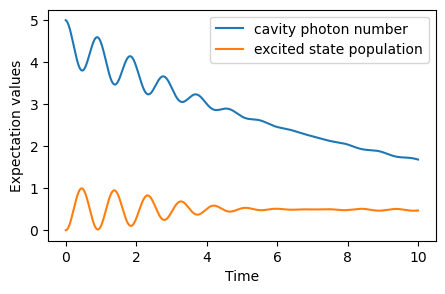

In [152]:
# short-time limit: damped Rabi oscillations
tlist = np.linspace(0,10,10000)
fock_space_size = 10
atom_space_size = 2
atom_cavity_coupling = 0.25
cavity_decay_rate = 0.1
initial_photon_number = 5

atom_fock_in_leaky_cavity(tlist, fock_space_size, atom_space_size, atom_cavity_coupling, cavity_decay_rate, initial_photon_number)


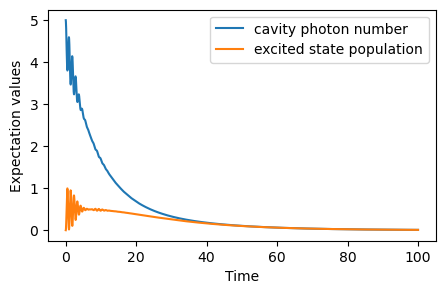

In [52]:
# long-time limit: no photons left, atom in ground state
tlist = np.linspace(0,100,10000)
fock_space_size = 10
atom_space_size = 2
atom_cavity_coupling = 0.25
cavity_decay_rate = 0.1
initial_photon_number = 5

atom_fock_in_leaky_cavity(tlist, fock_space_size, atom_space_size, atom_cavity_coupling, cavity_decay_rate, initial_photon_number)

What if the cavity is initially in a coherent state $\ket{\alpha}$ in a Hilbert space with size $N$? We expect to see Rabi oscillations getting washed out more due to there being a large number of Rabi frequencies. But we also expect to see collapse and revival in the case of low cavity decay due to constructive and destructive interferences of Rabi oscillations!

In [69]:
def atom_coherent_state_in_leaky_cavity(tlist, fock_space_size, atom_space_size, atom_cavity_coupling, cavity_decay_rate, coherent_alpha):
    # convention: atom X photons
    psi0_atom_fock = tensor(fock(atom_space_size,0), coherent(fock_space_size, coherent_alpha))
    a  = tensor(qeye(2), destroy(fock_space_size))
    sigma_minus = tensor(destroy(atom_space_size), qeye(fock_space_size))

    # Jaynes-Cummings Hamiltonian
    H = 2*np.pi*(a.dag()*a + sigma_minus.dag()*sigma_minus + atom_cavity_coupling * (sigma_minus * a.dag() + sigma_minus.dag() * a))

    # collapse operators:
    c_op_list = [np.sqrt(cavity_decay_rate)*a]

    # calculate
    result_atom_fock = mesolve(H, psi0_atom_fock, tlist, c_op_list, [a.dag()*a, sigma_minus.dag()*sigma_minus])

    # plot results at short-time limit:
    fig, ax = plt.subplots(figsize=(5,3))
    ax.plot(tlist, result_atom_fock.expect[0], label='cavity photon number')
    ax.plot(tlist, result_atom_fock.expect[1], label='excited state population')
    ax.legend()
    plt.ylabel('Expectation values')
    plt.xlabel('Time')
    plt.show()

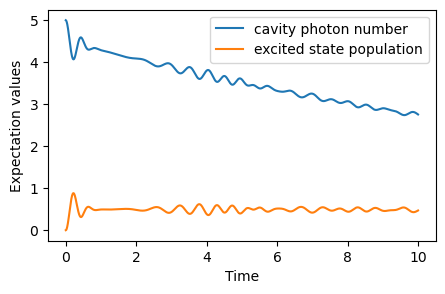

In [72]:
# short-time limit: damped Rabi oscillations
tlist = np.linspace(0,10,10000)
fock_space_size = 100
atom_space_size = 2
atom_cavity_coupling = 0.5
cavity_decay_rate = 0.05
coherent_alpha = np.sqrt(5)

atom_coherent_state_in_leaky_cavity(tlist, fock_space_size, atom_space_size, atom_cavity_coupling, cavity_decay_rate, coherent_alpha=coherent_alpha)


What if we have a thermal state instead? I was asked this question very early on in my PhD and I had idea how to answer it until later when I have some mental picture of what's supposed to happen. But now with QuTip I can explicitly calculate it. 

# <font size=5, color = 'black'> Three-level system: Two-photon damped Rabi-Raman oscillation </font>

Consider a three-level system given by $\ket{1}, \ket{2}, \ket{3}$ where $\ket{2}$ is some intermediate, lossy, excited level. Here, $\ket{1}, \ket{3}$ are the ground states (which are not necessarily degenerate). Assume that $\ket{1}, \ket{2}$ are coupled via a field with detuning $\Delta$ and Rabi frequency $\Omega_{12}$ and $\ket{2}, \ket{3}$ are coupled via a field with detuning $\Delta + \delta$ and Rabi frequency $\Omega_{23}$. We model the lossiness of state $\ket{2}$ by considering another dummy state $\ket{4}$ to which $\ket{2}$ decays with rate $\gamma_e$. With this we have an effective four-level system, but the point just to demonstrate damped two-photon Rabi-Raman damped oscillation. 

Assume that $\Delta \gg \gamma_e$ as typically is the case. Since we do not want the excited, lossy state $\ket{2}$ to participate much, we want to set the Rabi frequencies $\Omega_{12}, \Omega_{23}$ to be small compared to $\Delta$. This process is called adiabatic elimination. We set up our solver so that the initial state is $\ket{1}$.

The end results, which we will check, are that the ground states experience a light shift $\Omega_i^2/4\Delta$, and two-photon Rabi-Raman oscillation occurs with rate 
$$\Omega_\text{Rabi-Raman} = \frac{\Omega_{12}\Omega_{23} \Delta / 2   }{\Delta^2 + \gamma_e^2/4}$$ 
and is damped at rate
$$ \Gamma_\text{Rabi-Raman} = \frac{\Omega_{12} \Omega_{23} \gamma_e / 4}{ \Delta^2 + \gamma_e^2/4} .$$

In [49]:
 # Two-photon damped Rabi-Raman oscillation solver
def two_photon_rabi_raman_damped_oscillation(tlist, levels, gamma_e, Delta, delta, OmegaR_12, OmegaR_23, delta_24):

    one = levels[0]
    two = levels[1]
    three = levels[2]
    four = levels[3]

    # generate relevant projectors
    sig11 = one * one.dag()
    sig22 = two * two.dag()
    sig33 = three * three.dag()
    sig44 = four * four.dag()
    sig12 = one * two.dag()
    sig23 = two * three.dag()
    sig42 = four * two.dag() # |4><2| : sends |2> to |4>

    c_op_list = [np.sqrt(gamma_e)*sig42]

    H0 = Delta*sig11 + 0*sig22 + (Delta+delta)*sig33 + delta_24*sig44 # assuming |2> and |4> are degenerate, it doesn't matter!
    H1 = OmegaR_12*(sig12 + sig12.dag())/2.0 + OmegaR_23*(sig23 + sig23.dag())/2.0
    H = H0 + H1

    output = mesolve(H, one, tlist, c_op_list, [sig11, sig22, sig33, sig44])

    # calculate Rabi-Raman oscillation rate and Rabi-Raman damping rate:
    omega_Rabi_Raman = OmegaR_12 * OmegaR_23 * (Delta/2) / (Delta**2 + gamma_e**2/4)
    gamma_Rabi_Raman = OmegaR_12 * OmegaR_23 * (gamma_e/4) / (Delta**2 + gamma_e**2/4)

    fig, ax = plt.subplots(figsize=(5,3))
    ax.plot(tlist, output.expect[0], label='1')
    ax.plot(tlist, output.expect[1], label='2')
    ax.plot(tlist, output.expect[2], label='3')
    ax.plot(tlist, output.expect[3], label='4')
    ax.plot(tlist, np.cos(tlist * omega_Rabi_Raman/2)**2 *np.exp(-tlist * gamma_Rabi_Raman), ':' , label='analytics')
    plt.ylabel('Population')
    plt.xlabel('Time')
    ax.legend()
    plt.show()

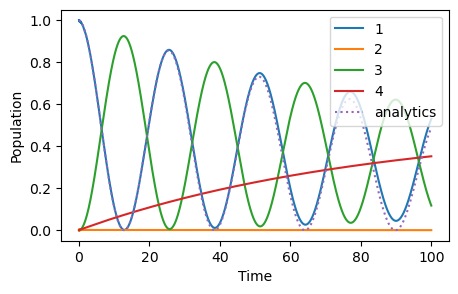

In [48]:
# Zero two-photon detuning case
gamma_e = 0.05*100
Delta = 100 # 12 detuning
delta = 0.0 # 13 two-photon detuning
OmegaR_12 = 7
OmegaR_23 = 7
delta_24 = 0.0 # energy difference between 2 & 4: it doesn't matter! 
tlist = np.linspace(0,100,100000)

# generate basis
one = basis(4,0)
two = basis(4,1)
three = basis(4,2)
four = basis(4,3)
four_levels = [one, two, three, four]

# calculate
two_photon_rabi_raman_damped_oscillation(tlist, four_levels, gamma_e, Delta, delta, OmegaR_12, OmegaR_23, delta_24)

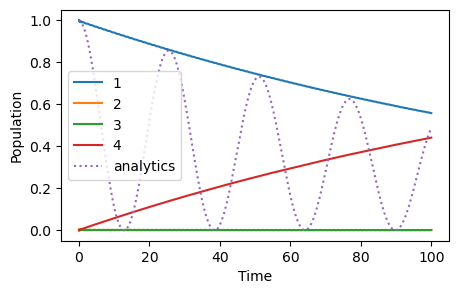

In [50]:
# Non-zero two-photon detuning case: garbage RR oscillation
gamma_e = 0.05*100
Delta = 100 # 12 detuning
delta = 5.0 # 13 two-photon detuning
OmegaR_12 = 7
OmegaR_23 = 7
delta_24 = 0.0 # energy difference between 2 & 4: it doesn't matter! 
tlist = np.linspace(0,100,100000)

# generate basis
one = basis(4,0)
two = basis(4,1)
three = basis(4,2)
four = basis(4,3)
four_levels = [one, two, three, four]

# calculate
two_photon_rabi_raman_damped_oscillation(tlist, four_levels, gamma_e, Delta, delta, OmegaR_12, OmegaR_23, delta_24)

# <font size=5, color='black'> STIRAP </font>

# <font size=5, color='black'>Radial Schrodinger equation solver (Numerov-Cooley method - unitless) </font>

In [4]:
# potential definitions and helper functions
def Vr_Morse(r, De, re, beta):
    return De*(1 - np.exp(-beta*(r-re)))**2 - De

def Vr_harmonic(r,omega,re):
    return (1/2)* omega**2 * (r-re)**2

def Vr_Lennard_Jones(r, lamb, re):
    return (lamb / re**2)*( (re/r)**12 - 2 * (re/r)**6 )

def Vr_hardcore(r,V, re):
    return -V * np.heaviside(re-r,1)

# find bound state energies for finite square well:
def bound_state_energies_finite_square_well(re, V):
    # cot is pi-periodic, so need to search for roots in intervals set by r_e * sqrt[V + E] = pi n
    E_intervals = []
    # returns all n's for which this is met:
    for n in range(0, int(np.ceil(np.sqrt(V) * re / np.pi) )):
        E_intervals.append( n**2 * np.pi**2 / re**2 - V)
    E_intervals = np.array(E_intervals)

    f = lambda E: -np.sqrt(-E) - np.sqrt(E+V) / np.tan(re * np.sqrt(V + E))
    E_root = []
    for i in range(E_intervals.size-1):
        # need to re-adjust values to make sure we're avoiding singularities
        E_min = E_intervals[i] + 1e-6
        E_max = E_intervals[i+1] - 1e-6 
        # now find a root of the transcendental equation within this range:
        E_root.append(scipy.optimize.brentq(f, E_min, E_max))
    E_root = np.array(E_root)
    return E_root

# calculate r which minimizes Vr:
def r_Vrmin(r,Vr):
    return r[np.argmin(Vr)], np.argmin(Vr)

# calculate turning points:
def turning_points(r,Vr, E_guess):
    tpts = np.where(np.diff(np.sign( Vr - E_guess )))[0]
    if tpts.size != 2:
        r1, r2 = (0,r.size-1)
    else:
        r1, r2 = tpts
    return r1, r2

# estimate spectrum up to k bound states:
def SE_radial_solver(r, Vr, l, num_states):
    # setting hbar**2/2m = 1
    energies, states = scipy.sparse.linalg.eigs(- FinDiff(0, r[1]-r[0], 2).matrix(r.shape) + scipy.sparse.diags(Vr + l*(l+1)/r**2), k=num_states, which='SR')
    for i in range(0,num_states):
        states[:,i] = states[:,i]/np.sqrt(scipy.integrate.simps(abs(states[:,i])**2, x=r))
    return energies #, states

In [5]:
# numerov calculate, for E_guess:
@jit(nopython=True, cache=True)
def numerov(r, gr, r_center_idx, l=0, dr=1e-3):
    u = np.zeros(r.size)
    # integrate forward to get u[0],...,u[r_center_idx]
    for j in np.linspace(0, r_center_idx, r_center_idx+1):
        i = int(j)
        if i == 0:
            u[i] = 0
        elif i == 1:
            u[i] = 1e-20
        else:
            u[i] = 2*(1 - (5/12)*gr[i-1]*dr**2)*u[i-1] - (1+gr[i-2]*dr**2/12)*u[i-2]
            u[i] /= 1 + gr[i]*dr**2/12 
    # normalize to match wfns
    u[0:r_center_idx] /= u[r_center_idx]
    # integrate backward to get u[r_center_idx],...,u[r.size-1], overwriting u[r_center_idx]
    for j in np.linspace(r.size-1, r_center_idx, r.size - r_center_idx):
        i = int(j)
        if i == r.size-1:
            u[i] = 0
        elif i == r.size-2:
            u[i] = 1e-20
        else:
            u[i] = 2*(1 - (5/12)*gr[i+1]*dr**2)*u[i+1] - (1+gr[i+2]*dr**2/12)*u[i+2]
            u[i] /= 1 + gr[i]*dr**2/12
    # normalize to match wfns    
    u[r_center_idx:r.size-1] /= u[r_center_idx]

    return u

In [6]:
# Numerov-Cooley optimization
def numerov_optimize(r, Vr, E_guess, r_center_idx, l=0, E_tolerance=1e-5, max_iter=1e5, method='slope', cst = 1, verbose = False):
    # calculate u and initialize:
    dr = abs(r[0] - r[1])
    Veff = Vr + l*(l+1)/r**2
    gr = cst*(E_guess - Veff) # cst = 2m / hbar**2
    u = numerov(r, gr, r_center_idx, l=l, dr=dr)
    if method == 'slope':
        slope_out  = (u[r_center_idx] - u[r_center_idx-1])/(r[r_center_idx] - r[r_center_idx-1])
        slope_in = (u[r_center_idx+1] - u[r_center_idx+0])/(r[r_center_idx+1] - r[r_center_idx+0])
        E_corr = (slope_out - slope_in)/scipy.integrate.simps(abs(u)**2,r)
    elif method == 'Cooley':
        Y = (1 + gr*dr**2/12)*u
        E_corr = (-Y[r_center_idx-1]+2*Y[r_center_idx]-Y[r_center_idx+1])/dr**2 + gr[r_center_idx]*u[r_center_idx]
        E_corr /= abs(sum(u[:]*np.conjugate(u[:])))
    else: 
        print('Invalid iteration method!')
        return u, E_guess
    
    iteration = 0
    while True:
        if abs(E_corr) >= E_tolerance:
            if iteration <= max_iter:
                # correct E_guess
                E_guess = E_guess + E_corr
                # update wfn
                Veff = Vr + l*(l+1)/r**2
                gr = cst*(E_guess - Veff) # cst = 2m / hbar**2
                u = numerov(r, gr, r_center_idx, l=l, dr=dr) 
                if method == 'slope':
                    slope_out  = (u[r_center_idx] - u[r_center_idx-1])/(r[r_center_idx] - r[r_center_idx-1])
                    slope_in = (u[r_center_idx+1] - u[r_center_idx+0])/(r[r_center_idx+1] - r[r_center_idx+0])
                    E_corr = (slope_out - slope_in)/scipy.integrate.simps(abs(u)**2,r)
                elif method == 'Cooley':
                    Y = (1 + gr*dr**2/12)*u
                    E_corr = (-Y[r_center_idx-1]+2*Y[r_center_idx]-Y[r_center_idx+1])/dr**2 + gr[r_center_idx]*u[r_center_idx]
                    E_corr /= abs(sum(u[:]*np.conjugate(u[:])))
                iteration += 1

                # update r_center_idx:
                # find r_center_idx at which the solution from the inward integration is maximized:
                r_center_idx = np.argmax(abs(u[r_center_idx:r.size].real)) + r_center_idx
            else:
                if verbose:
                    print('Max iteration exceeded!')
                    print('Iteration completed, last iteration: ' + str(iteration))
                    print('Iteration completed, last correction: ' + str(E_corr))
                    print('Final energy: ' + str(E_guess))
                break
        else:
            if verbose:
                print('Iteration completed, last iteration: ' + str(iteration))
                print('Iteration completed, last correction: ' + str(E_corr))
                print('Final energy: ' + str(E_guess))
            break
    # finally, normalize total wfn:
    u /= np.sqrt(scipy.integrate.simps(abs(u)**2, x=r))
    return u, E_guess

In [136]:
# generate E_guess using WKB:
def WKB_integral(E_guess, r, Vr, v, cst = 1):
    return abs(np.trapz(np.sqrt(np.heaviside(E_guess - Vr,1)*cst*(E_guess - Vr)),r) - (v+1/2)*np.pi)

def WKB_energy(r, Vr, v, cst = 1):
    v = np.array(v)
    result = np.array([])
    for v_level in v:
        res = scipy.optimize.fsolve(WKB_integral, args = (r, Vr, v_level, cst), x0 = min(Vr[0], Vr[-1]))
        result = np.append(result, res[0])
    return result

## <font size=3, color=37A5C0> Example 1: Morse potential </font>

The Morse potential is given by 
$$ V(r) = D_e (1 - \exp(-\beta (r - r_e))) - D_e $$
where $D_e$ is the dissociation energy, $r_e$ is the equilibrium bond length, and $1/\beta$ is the effective range of the potential. The Morse potential is one of the very few that can be solved exactly. By setting $\hbar^2 / 2\mu = 1$ in the SE, we find that the spectrum for this potential is 
$$ E_n =  \beta \sqrt{4D_e} \left( n + \frac{1}{2}\right)    - \beta^2 \left( n + \frac{1}{2} \right)^2 - D_e.$$  
Note that this spectrum is only correct for $s$-wave interaction, i.e. $l=0$.

Spectrum:
[-178.79853835 -160.28342563 -142.78006034 -126.28844249 -110.80857207
  -96.34044909  -82.88407355  -70.43944543  -59.00656476  -48.58543152
  -39.17604571  -30.77840734  -23.3925164   -17.0183729   -11.65597683
   -7.3053282    -3.96642701   -1.63927324]
E guess:
[-178.80084026 -142.80480653  -96.42494985  -70.56192912  -39.32989413
  -17.15889651]
-178.7985139555214
-142.78001966256366
-96.34041676045969
-70.43941945670733
-39.17602863772304
-17.01836366485556


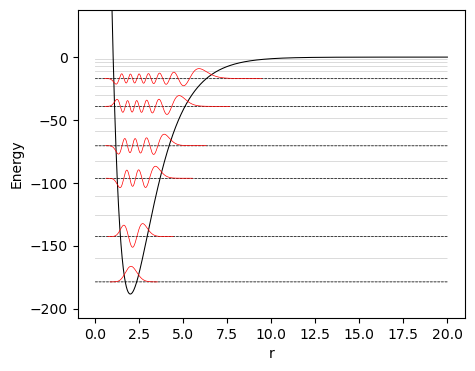

In [1653]:
# Morse potential
rmin = 1e-10
rmax = 20
rpoints = 10000000
r = np.linspace(rmin,rmax,rpoints)
De = 188.4355 # following example from Cooley's 1961 paper
re = 1.9975
beta = 0.711248
Vr = Vr_Morse(r, De, re, beta)

# setup solver
n = np.array([0,2,5,7,10,13])
num_states = max(n)+5
# this spectrum only works for l = 0
spec = beta*np.sqrt(4*De)*(np.linspace(0,num_states-1,num_states)+1/2) - beta**2 *(np.linspace(0,num_states-1,num_states)+1/2)**2 - De
print('Spectrum:')
print(spec)

# use Scipy to estimate spectrum and get E_guess
guess_spectrum = SE_radial_solver(r=r[::int(rpoints/1000)],Vr=Vr[::int(rpoints/1000)], l=0, num_states=num_states)
E_guess = guess_spectrum.real[n]
print('E guess:')
print(E_guess)

# plot potential, E_guess, spectrum, and final wfn
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(r[::100], Vr[::100],'k',linewidth=0.75)
for i in range(num_states):
    ax.plot(r[::5], np.ones(r[::5].size)*spec[i],'k',linewidth=0.1)
for state_idx in range(0,n.size):
    # plot E_guesses:
    ax.plot(r[::100], E_guess[state_idx]*np.ones(r[::100].size), 'k', linewidth=0.5,linestyle='--')
    # solve and optimize  
    r_left_idx, r_right_idx = turning_points(r, Vr, E_guess[state_idx])
    r_left_idx = int(r_left_idx/2)
    r_right_idx = int(r_right_idx * 1.5)
    r_center_idx = int((r_left_idx + r_right_idx)/2) - r_left_idx
    u_final, E_final = numerov_optimize(r[r_left_idx:r_right_idx], 
                                        Vr[r_left_idx:r_right_idx], 
                                        E_guess[state_idx], r_center_idx, l=0, E_tolerance=1e-6, max_iter = 100, method='slope', verbose=False)
    print(E_final)
    # plot results
    scale = De/20
    ax.plot(r[r_left_idx:r_right_idx:2],scale*u_final[::2]+E_final, 'red',linewidth=0.5)
plt.ylim([-1.1*De, 0.2*De])
plt.xlabel('r')
plt.ylabel('Energy')
plt.show()

## <font size=3, color=37A5C0> Example 2: Lennard-Jones potential </font>

The Lennard-Jones potential has the form:
$$ V(r) =  \frac{\lambda}{r_e^2} \left[ \left( \frac{r_e}{r} \right)^{12} - 2 \left( \frac{r_e}{r} \right)^6 \right] $$ 

E guess:
[-50.10397577]
-50.09406738942048


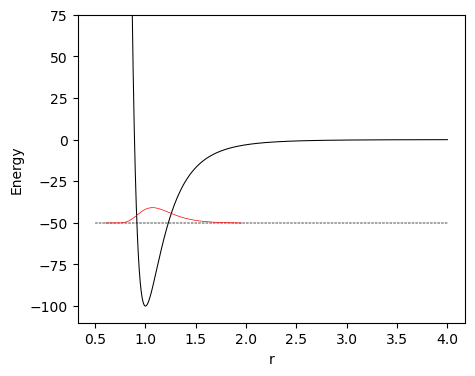

In [225]:
# Lennard-Jones potential
rmin = 0.5
rmax = 4.0
rpoints = 20000000
r = np.linspace(rmin,rmax,rpoints)
re = 1
lamb = 100
l = 0
Vr = Vr_Lennard_Jones(r, lamb, re)

# use Scipy to estimate spectrum and get E_guess
num_states = 1
guess_spectrum = SE_radial_solver(r=r[::int(rpoints/500)],Vr=Vr[::int(rpoints/500)], l=l, num_states=num_states)
E_guess = guess_spectrum.real
print('E guess:')
print(E_guess)

# plot potential, E_guess, spectrum, and final wfn
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(r[::100], Vr[::100],'k',linewidth=0.75)

for state_idx in range(0,num_states):
    # plot E_guesses:
    ax.plot(r[::100], E_guess[state_idx]*np.ones(r[::100].size), 'k', linewidth=0.5,linestyle='--')
    # solve and optimize  
    r_left_idx, r_right_idx = turning_points(r, Vr, E_guess[state_idx])

    r_left_idx = int(r_left_idx/4) 
    r_right_idx = min( int(r_right_idx * 2), r.size-1)
    r_center_idx = int((r_left_idx + r_right_idx)/2) - r_left_idx

    u_final, E_final = numerov_optimize(r[r_left_idx:r_right_idx], 
                                        Vr[r_left_idx:r_right_idx], 
                                        E_guess[state_idx], r_center_idx, l=l, E_tolerance=1e-7, max_iter = 100, method='Cooley', verbose=False)
    print(E_final)
    # plot results
    scale = lamb/20
    ax.plot(r[r_left_idx:r_right_idx:2],scale*u_final[::2]+E_final, 'red',linewidth=0.5)
plt.ylim([-1.1*lamb,0.75*lamb])
plt.xlabel('r')
plt.ylabel('Energy')
plt.show()

## <font size=3, color=37A5C0> Example 3: Square well potential and the scattering length </font>

Consider a finite square well potential of the form $V(r) = V_0 \Theta(R_e - r)$, with $r \geq 0$. 

For bound states, $-V_0 \leq E < V_\text{max} = 0$. The in order for the wavefunctions to be continuous and differentiable, it is required that $ -\sqrt{- E} = \sqrt{ E +V_0} \cot \left( R_e \sqrt{E + V_0}\right) $ (one derives this condition the usual way plus noting the fact that $u(0) = 0$). This is a transcendental equation which must be solved numerically. For example, let $R_e = 2, V_0 = 100$. Then we have $$E = -97.76, -91.06, -79.93, -64.43, -44.72, -21.17.$$ There are 6 bound states in this case. 

Number of bound states: 
9
Analytic E guess: 
[-98.97309993 -95.89379161 -90.76644746 -83.59908438 -74.40477116
 -63.20450162 -50.03354685 -34.95815154 -18.13691785]
NC Bound state energy: -98.97310034289661
NC Bound state energy: -95.89378261752437
NC Bound state energy: -90.7664331605326
NC Bound state energy: -83.59905962856706
NC Bound state energy: -74.40473340106533
NC Bound state energy: -63.2044477490118
NC Bound state energy: -50.0334781549896
NC Bound state energy: -34.95806249922485
NC Bound state energy: -18.136813746911404


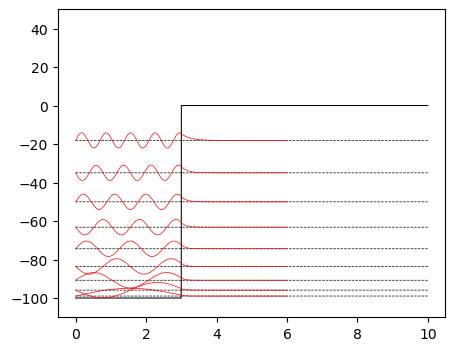

In [300]:
# square well potential
rmin = 1e-6
rmax = 10
rpoints = 1000000
r = np.linspace(rmin, rmax, rpoints)
V = 100
l = 0
re = 3
Vr = Vr_hardcore(r,V,re)

#############################################
######### BOUND STATE SEARCH ################
#############################################

# use analytics to estimate spectrum and get E_guess:
E_guess = bound_state_energies_finite_square_well(re, V)
print('Number of bound states: ')
num_states = E_guess.size
print(num_states)
print('Analytic E guess: ')
print(E_guess)

# plot potential, E_guess, spectrum, and final wfn
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(r[::100], Vr[::100],'k',linewidth=0.75)

r_left_idx = 0
r_right_idx = 2 * int(re * r.size/(rmax - rmin))
r_center_idx = int(r.size // int( (rmax - rmin) / re)  )

for state_idx in range(0,num_states):
    # plot E_guesses:
    ax.plot(r[::100], E_guess[state_idx]*np.ones(r[::100].size), 'k', linewidth=0.5,linestyle='--')
    # solve and optimize  
    u_final, E_final = numerov_optimize(r[r_left_idx:r_right_idx], 
                                        Vr[r_left_idx:r_right_idx], 
                                        E_guess[state_idx], r_center_idx, l=l, E_tolerance=1e-7, max_iter = 100, method='Cooley', verbose=False)
    print('NC Bound state energy: ' + str(E_final))
    # plot results
    scale = V/20
    ax.plot(r[r_left_idx:r_right_idx:2],scale*u_final[::2]+E_final, 'red',linewidth=0.5)
plt.ylim([-1.1*V, 0.5*V])
plt.show()

It turns out that there is a threshold behavior in 3D (as in our case here). The potential well could be too shallow to host a bound state (unlike in 1D or 2D). This is due to the boundary condition $u(0) = rR(r) = 0$, which does not arise in one or two dimensions. What is this threshold? One can derive it from the requirement that $0 < n^2 < VR_e^2/\pi^2$. The result is that a bound state exists only for $V > (\pi/R_e)^2$.  When on bound state exists, the ground state of the system is a scattering state. 

Number of bound states: 
7
Bound and scattering state energy guesses:
[-52.8314027  -49.82545764 -44.82773555 -37.86034929 -28.96551031
 -18.23372127  -5.95136822   1.        ]
NC Bound state energy: -52.83140248114112
NC Bound state energy: -49.825450084048725
NC Bound state energy: -44.827722180125335
NC Bound state energy: -37.86032666500178
NC Bound state energy: -28.965477984778307
NC Bound state energy: -18.23368125569271
NC Bound state energy: -5.951317291573732
NC Scattering state energy: 1.7852312526946448


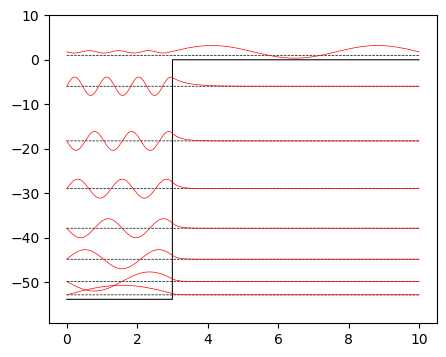

In [328]:
# square well potential
rmin = 1e-6
rmax = 10
rpoints = 1000000
r = np.linspace(rmin, rmax, rpoints)
re = 3
n = 7 # gives the number of bound states
V = (n*np.pi/re)**2 + 0.1
l = 0
Vr = Vr_hardcore(r,V,re)

#############################################
######### BOUND STATE SEARCH ################
#############################################

# use analytics to estimate spectrum and get E_guess:
E_guess = bound_state_energies_finite_square_well(re, V)
print('Number of bound states: ')
num_states = E_guess.size
print(num_states)
# print('Analytic E guess: ')
# print(E_guess)

# add guesses for scattering states:
print('Bound and scattering state energy guesses:')
E_guess = np.append(E_guess, 1.0)
num_states = E_guess.size
print(E_guess)

# plot potential, E_guess, spectrum, and final wfn
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(r[::100], Vr[::100],'k',linewidth=0.75)

r_left_idx = 0
r_right_idx = r.size - 1
r_center_idx = int(r.size // int( (rmax - rmin) / re)  )

for state_idx in range(0,num_states):
    # plot E_guesses:
    ax.plot(r[::100], E_guess[state_idx]*np.ones(r[::100].size), 'k', linewidth=0.5,linestyle='--')
    # solve and optimize  
    u_final, E_final = numerov_optimize(r[r_left_idx:r_right_idx], 
                                        Vr[r_left_idx:r_right_idx], 
                                        E_guess[state_idx], r_center_idx, l=l, E_tolerance=1e-7, max_iter = 100, method='Cooley', verbose=False)
    if E_final < Vr[-1]:
        print('NC Bound state energy: ' + str(E_final))
    else:
        print('NC Scattering state energy: ' + str(E_final))
    # plot results
    scale = V/20
    ax.plot(r[r_left_idx:r_right_idx:2],scale*u_final[::2]+E_final, 'red',linewidth=0.5)
plt.ylim([-1.1*V, 10])
plt.show()

We notice that the wavefunction $u(r) = rR(r)$ looks like $\sin(kr + \delta(k))$ far from the potential well. The phase shift $\delta(k)$ is related to the scattering length $a$ defined as 

$$ a = \lim_{k \ll 1/R_e} \frac{\tan \delta(k)}{k} $$

In ultracold atom experiments, $k$ is very small and in particular the de Broglie wavelength $\lambda_{dB} \sim 1/k$ is very large, much larger than the effective range of the potential well. As a result, we don't think about the microscopic details of the potential (unless we're worried about the bound state wavefunctions) and think only about the phase shift of the wavefunction $rR(r)$ due to the existence of the potential well. The scattering length basically tells us how much the wavefunction has been shifted from the origin due to the potential well. This shift $a$ can be positive, negative, or infinite. Without worrying about Bessel functions (which arise if we treat this problem with partial waves), we can have this mental picture to keep things simple. 

# <font size=5, color='black'>Electronic potentials and their eigenstates of NaK</font>

This section will eventually become part of the Fermi1 Calculator notebook. This section will also use methods developed in the previous section where the Numerov-Cooley method is used to generate wavefunctions and calculate stuff. The potential curves here are generated from known spectroscopy data for Na23-K39. Mass scaling is needed to generate potential curves for Na23-K40, but it is not crucial. Mass scaling can only be applied to potentials generated using Dunham coefficients and the Rydberg-Klein-Rees (RKR) procedure. 

There are several things that we are calculating here. 

We first calculate the wavefunctions for the $X^1 \Sigma^+$ absolute ground state $\ket{\nu = 0}$ and for the $a^3 \Sigma^+$ vibration state $\ket{\nu = 19}$. We can also check that $\nu = 19$ is the most energetic bound state of the $a^3 \Sigma^+$ potential, which agrees with the result found in Tiemann et al (2008). This makes sense, since the $a^3 \Sigma^+$ potential was generated using their formula. Note, however, that the formula for the $X^1 \Sigma^+$ potential is most likely faulty. I'm using Scipy's interpolation function on the data provided in Table 5 of I Russier-Antoine et al (2000) to get the $X^1 \Sigma^+$ curve. 

For future reference, we provide here a table with Dunham coefficients and how they translate to molecular constants:

$$ \begin{align*}
Y_{10} &= \omega_e\\
Y_{01} &= B_e\\
Y_{02} &= D_e \\
Y_{03} &= F_e \\
Y_{20} &= -\omega_e x\\  
Y_{11} &= -\alpha_e \\
Y_{12} &= \beta_e  \\
Y_{04} &= H_e \\
Y_{30} &= \omega_e y\\  
Y_{21} &= \gamma_e \\
Y_{40} &= \omega_e z\\ 
\end{align*} $$


In [8]:
# RKR procedure: 

def RKR_T(v,Y,J=0): # verified correct
    T=0
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            T += Y[i][j] * (v+1/2)**i * (J*(J+1))**j
    return T

def RKR_B(v,Y): # should be correct
    B = 0
    for i in range(Y.shape[0]):
        B += Y[i][1] * (v + 1/2)**i
    return B

def RKR_s(v, Y): # should be correct
    s = 0
    for i in range(Y.shape[0]-1):
        s += (i+1) * Y[i+1][0] * (v+1/2)**i
    return s

def RKR_f(v,Y,J=0):
    df = 1e-10
    first_term, first_term_err = scipy.integrate.quad(lambda n: 1/np.sqrt(RKR_T(v,Y,J) - RKR_T(n,Y,J)), -0.5, v-df, epsabs=1e-10, epsrel=1e-10)
    second_term = 2 * np.sqrt(df / RKR_s(v,Y))   
    return first_term + second_term

def RKR_g(v,Y,J=0):
    df = 1e-10
    first_term, first_term_err = scipy.integrate.quad(lambda ns: RKR_B(ns,Y)/np.sqrt(RKR_T(v,Y,J) - RKR_T(ns,Y,J)), -0.5, v-df, epsabs=1e-10, epsrel=1e-10)
    second_term = RKR_B(v,Y) * 2 * np.sqrt(df /RKR_s(v,Y))   
    return first_term + second_term

def RKR_r1r2(v,Y,J=0):
    f = RKR_f(v,Y,J) 
    g = RKR_g(v,Y,J)
    r1 = (RKRcst/np.sqrt(muNa39K)) * ( np.sqrt(f/g + f**2) - f  )
    r2 = (RKRcst/np.sqrt(muNa39K)) * ( np.sqrt(f/g + f**2) + f  )
    Vr = RKR_T(v, Y, J)
    return r1, r2, Vr

def RKR_mass_scaled_Y(Y, initial='39K', final='40K'):
    # formulas from Dunham's 1932 paper
    Y_corr = np.copy(Y)
    beta = np.copy(Y*0)
    # the coefs above are for 23Na-39K. We need to rescale to get 23Na-40K. 
    # mass-rescaling... act on Yij. More details can be found in Dunham's 1932 paper
    a1 = Y[1][1]*Y[1][0]/(6*Y[0][1]**2) - 1
    beta[0][1] = Y[1][0]**2 * Y[2][1]/(4*Y[0][1]**3) + 16*a1*Y[2][0]/(3*Y[0][1])- 8*a1 - 6*a1**2 + 4*a1**3
    beta[1][0] = 5*Y[1][0]*Y[3][0]/(4*Y[0][1]**2) + a1*Y[1][0]**2*Y[2][1]/(3*Y[0][1]**3) - 10*a1 - 20*a1**2 - 15*a1**3/2 - (5*a1**4)/2 + Y[2][0]*(4*a1+(16*a1**2) / 3)/Y[0][1] + Y[2][0]**2/(2*Y[0][1]**2)
    beta[0][2] = 73/2 + 37*a1 + 67*a1**2/2 + 33*a1*3 - 6*a1**4 - 9*Y[1][0]*Y[3][0]/(2*Y[0][1]**2) + Y[1][0]**2*Y[2][1]*(3-11*a1/6)/(2*Y[0][1]**3) - Y[2][0]*(130/3+4*a1+74*a1**2/3)/(2*Y[0][1]) + (31*Y[2][0]**2)/(9*Y[0][1]**2)

    # print('Typical correction:')
    # print(beta[0][1] * (Y[0][1]/Y[1][0])**2 * (muNa39K - muNa40K)/muNa40K) # = -1.49683e-7 verified

    # now generate Y_corr[i][j]
    if initial == '39K' and final == '40K':
        for i in range(Y_corr.shape[0]):
            for j in range(Y_corr.shape[1]):
                # note: Y01 ~ Be, the vibrational constant... Y10 ~ \omega_e, the vibrational frequency (see Dunham's paper)
                # mass-scaling: see Dunham's paper for formula 
                Y_corr[i][j] = Y[i][j] * (muNa39K/muNa40K)**(i/2 + j) * (1 + beta[i][j] * (Y[0][1]/Y[1][0])**2 * (muNa39K - muNa40K)/muNa40K) 
    return Y_corr

In [9]:
# cm-1 to nm:
def cm1_to_nm(cm1):
    wavelength_nm = (( 1/cm1 )/100) * 1e9
    return wavelength_nm

In [183]:
# bound state energies in cm-1:
def bound_state_energies_cm1(potential = 'c3SigmaPlus', mass_scaled=False):

    if potential == 'c3SigmaPlus':
        Y = Y_Na39K_c3SigmaPlus
        v_max = v_max_c3SigmaPlus
    if potential == 'b3Pi':
        Y = Y_Na39K_b3Pi
        v_max = v_max_b3Pi
    if potential == 'A1SigmaPlus':
        Y = Y_Na39K_A1SigmaPlus
        v_max = v_max_A1SigmaPlus
    if potential == 'B1Pi':
        Y = Y_Na39K_B1Pi
        v_max = v_max_B1Pi
    if potential == 'X1SigmaPlus':
        print('Not supported!')
        return 
    if potential == 'a3SigmaPlus':
        print('Not supported!')
        return 

    if mass_scaled:
        Y = RKR_mass_scaled_Y(Y=Y, initial='39K', final='40K')
    bound_state_energies = np.array([])
    for v in range(v_max):
        bound_state_energies = np.append(bound_state_energies, RKR_T(v=v, Y=Y))
    return bound_state_energies


In [185]:
# PA lines
def PA_lines_cm1(potential = 'c3SigmaPlus', mass_scaled = False):
    
    if potential == 'c3SigmaPlus':
        Y = Y_Na39K_c3SigmaPlus
        v_max = v_max_c3SigmaPlus
        Te = Te_c3SigmaPlus
    if potential == 'b3Pi':
        Y = Y_Na39K_b3Pi
        v_max = v_max_b3Pi
        Te = Te_b3Pi
    if potential == 'A1SigmaPlus':
        Y = Y_Na39K_A1SigmaPlus
        v_max = v_max_A1SigmaPlus
        Te = Te_A1SigmaPlus
    if potential == 'B1Pi':
        Y = Y_Na39K_B1Pi
        v_max = v_max_B1Pi
        Te = TeB1Pi
    if potential == 'X1SigmaPlus':
        print('Not supported!')
        return 
    if potential == 'a3SigmaPlus':
        print('Not supported!')
        return 
    
    if mass_scaled:
        Y = RKR_mass_scaled_Y(Y=Y, initial='39K', final='40K')
        
    PA_lines = np.array([])
    for v in range(v_max):
        PA_lines = np.append(PA_lines, RKR_T(v=v, Y=Y) - DeX + Te - Y[0][0])
    return PA_lines


In [11]:
def Vr_X1SigmaPlus(r):
    # data: https://iopscience.iop.org/article/10.1088/0953-4075/33/14/312/pdf
    # use this instead of the analytic expression found in the 2008 paper. I think there's a typo somewhere that causes the math to go haywire!
    r_X1SigmaPlus_data = [2.20, 2.30, 2.40, 2.50, 2.52, 2.54, 2.56, 2.58, 2.60, 2.62, 2.64, 2.66, 2.68, 2.70, 2.72, 2.74, 2.76, 2.78, 2.80, 2.82, 2.84, 2.86, 2.88, 2.90, 2.92, 
                      2.94, 2.96, 2.98, 3.00, 3.02, 3.04, 3.06, 3.08, 3.10, 3.12, 3.14, 3.16, 3.18, 3.20, 3.22, 3.24, 3.26, 3.28, 3.30, 3.32, 3.34, 3.36, 3.38, 3.40, 3.41, 
                      3.42, 3.43, 3.44, 3.45, 3.46, 3.47, 3.48, 3.49, 3.499,3.50, 3.51, 3.52, 3.53, 3.54, 3.55, 3.56, 3.57, 3.58, 3.59, 3.60, 3.62, 3.64, 3.66, 3.68, 3.70, 
                      3.72, 3.74, 3.76, 3.78, 3.80, 3.82, 3.84, 3.86, 3.88, 3.90, 3.92, 3.94, 3.96, 3.98, 4.00, 4.10, 4.20, 4.30, 4.40, 4.50, 4.60, 4.70, 4.80, 4.90, 5.00, 
                      5.10, 5.20, 5.30, 5.40, 5.50, 5.60, 5.70, 5.80, 5.90, 6.00, 6.20, 6.40, 6.60, 6.80, 7.00, 7.20, 7.40, 7.60, 7.80, 8.00, 8.20, 8.40, 8.60, 8.80, 9.00, 
                      9.20, 9.40, 9.60, 9.80, 10.0, 10.2, 10.4, 10.6, 10.8, 11.0, 11.2, 11.4, 11.6, 11.8, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0]
    Vr_X1SigmaPlus_data = [11594.8205, 9104.0944, 7148.9304, 5641.1076, 5379.0866, 5095.6036, 4823.1326, 4574.8666, 4335.2158, 4101.5627, 3876.1750, 3659.7766, 3451.8645, 
                        3251.9080 , 3059.6364, 2874.9030, 2697.5617, 2527.4376, 2364.3427, 2208.0948, 2058.5259, 1915.4819, 1778.8181, 1648.3948, 1524.0743, 1405.7194, 
                        1293.1930 , 1186.3584, 1085.0800,  989.2236,  898.6573,  813.2510,  732.8771,  657.4104,  586.7276,  520.7076,  459.2310,  402.1798,  349.4376, 
                            300.8889 ,  256.4198,  215.9173,  179.2693,  146.3655,  117.0967,   91.3555,   69.0340,   50.0283,   34.2368,   27.5151,   21.5596,   16.3573, 
                            11.8954 ,    8.1616,    5.1439,    2.8304,    1.2098,    0.2707,    0.0028,    0.0022,    0.3935,    1.4324,    3.1073,    5.4066,    8.3190, 
                            11.8334 ,   15.9392,   20.6257,   25.8827,   31.7002,   44.9761,   60.3701,   77.8011,   97.1892,  118.4575,  141.5314,  166.3370,  192.8016, 
                            220.8548 ,  250.4275,  281.4525,  313.8640,  347.5980,  382.5918,  418.7845,  456.1167,  494.5303,  533.9688,  574.3769,  615.7010,  834.2691, 
                            1068.3980, 1312.7365, 1562.6259, 1814.0573, 2063.6173, 2308.4280, 2546.0945, 2774.6669, 2992.6125, 3198.7896, 3392.4155, 3573.0292, 3740.4516, 
                            3894.7449, 4036.1749, 4165.1739, 4282.3053, 4388.2299, 4483.6737, 4646.1811, 4775.9576, 4878.7989, 4959.8628, 5023.5554, 5073.5304, 5112.7514, 
                            5143.5817, 5167.8821, 5187.1056, 5202.3822, 5214.5790, 5224.3635, 5232.2613, 5238.6730, 5243.9111, 5248.2177, 5251.7814, 5254.7491, 5257.2360, 
                            5259.3323, 5261.1096, 5262.6249, 5263.9233, 5265.0412, 5266.0079, 5266.8473, 5267.5790, 5268.2191, 5268.7809, 5270.7459, 5271.8470, 5272.4949, 
                            5272.8916, 5273.1427, 5273.3063]
    r_X1SigmaPlus_data  = np.array(r_X1SigmaPlus_data)
    Vr_X1SigmaPlus_data = np.array(Vr_X1SigmaPlus_data)
    # finally, shift this so that the minimum is at -5272.6205, according to the Tiemann 2008 paper.
    Vr_X1SigmaPlus_data = Vr_X1SigmaPlus_data - 5272.6205
    # now interpolate based on the size of the numpy array r:
    Vr_X1SigmaPlus_interpolate = scipy.interpolate.CubicSpline(r_X1SigmaPlus_data, Vr_X1SigmaPlus_data)
    return Vr_X1SigmaPlus_interpolate(r)


In [12]:
def Vr_a3SigmaPlus(r):
    # X1Sigma+ potential of NaK
    # reference: https://link.springer.com/article/10.1140/epjd/e2008-00138-7
    # Note that the values for the ground state potentials are for the 23Na39K isotope. 
    # units: Angstrom and cm-1
    
    Ri = 4.55 # connection point between the short-range U_SR(r) and series-expanded U(r)
    Ro = 11.3 # connection point between the series-expanded U(r) and the long-range U_LR(r)
    Rm = 5.47298825 # chosen to be close to the equilibrum internuclear distance
    A  = -0.6838392e3  
    B  = +0.281763541e6 
    q  = 4
    b = -0.66
    a = np.array([-207.7495,
                  0.104345e2,
                  0.3811560e3, 
                  0.2432236e3, 
                  0.182422e2, 
                  -0.1183588e3, 
                  -0.5243827e3, 
                  -0.7362683e3, 
                  0.12436734e4, 
                  0.13720076e4, 
                  -0.40511451e4, 
                  -0.25977888e4, 
                  0.59928116e4, 
                  0.37710157e4, 
                  -0.29764114e4, 
                  -0.20459436e4])
    
    C6 = 0.1179302e8
    C8 = 0.3023023e9
    C10 = 0.9843378e10
    Aex = 0.1627150e4
    gam = 5.25669
    bet = 2.11445

    U = np.zeros(r.size)

    for i in range(r.size):
        if r[i] < Ri:
            U[i] = A + B/ (r[i]**q)
        elif Ri <= r[i] <= Ro:
            for k in range(a.size):
                U[i] +=  a[k] * ( (r[i] - Rm) / (r[i] + b * Rm) )**k
        elif r[i] > Ro:
            E_ex = Aex * r[i]**gam *np.exp(- bet * r[i])
            U[i] = -C6/r[i]**6 - C8/r[i]**8 - C10/r[i]**10  - E_ex # final minus singlet state
    return U
    
    

In [155]:
def Vr_B1Pi(r, mass_scaled = True, no_kink=True):
    Y = Y_Na39K_B1Pi
    
    # now generate mass-scaled Y[i][j] from muNa39K to muNa40K
    if mass_scaled:
        Y = RKR_mass_scaled_Y(Y, initial='39K', final='40K')

    # next, generate Vr data from RKR procedure for interpolation:
    vs = np.linspace(0,v_max_B1Pi,v_max_B1Pi+1)
    vs = vs.astype(int)
    r_B1Pi_data = []
    Vr_B1Pi_data = []
    r_B1Pi_short_range_data = []
    Vr_B1Pi_short_range_data = []
    for v in vs:
        rmin, rmax, U = RKR_r1r2(v=v, Y=Y, J=0) # rotationless 
        r_B1Pi_data.append(rmin)
        Vr_B1Pi_data.append(U)
        r_B1Pi_data.append(rmax)
        Vr_B1Pi_data.append(U)
        r_B1Pi_short_range_data.append(rmin)
        Vr_B1Pi_short_range_data.append(U)
    # numpize data for interpolation later
    r_B1Pi_data = np.array(r_B1Pi_data)
    Vr_B1Pi_data = np.array(Vr_B1Pi_data)
    r_B1Pi_short_range_data = np.array(r_B1Pi_short_range_data)
    Vr_B1Pi_short_range_data = np.array(Vr_B1Pi_short_range_data)

    # We can't interpolate this data yet because of a "backbend" issue for v = 35 to 43 at small r (plot this and see for yourself!
    # to fix the backbend issue by fixing some values of r: do this using the fitted form of potential in short-range:
    def sr(z, A, B):
        return A + B/z**12
    def lr(z, De, C6, C8, C10):
        return De - C6/z**6 - C8/z**8 - C10/z**10
        
    Vr_B1Pi_data_corrected = np.copy(Vr_B1Pi_data) # nothing to correct here, but good for readability
    r_B1Pi_data_corrected  = np.copy(r_B1Pi_data)
    sort_sr_data = np.argsort(Vr_B1Pi_short_range_data)

    v_start = 30
    v_end   = 34
    # fit the short-range to inner turning points associated with v = 30 to v = 34.
    r_sr_backbend_fix = np.copy( r_B1Pi_short_range_data[sort_sr_data])[v_start:(v_end+1)]
    V_sr_backbend_fix = np.copy(Vr_B1Pi_short_range_data[sort_sr_data])[v_start:(v_end+1)]

    backbend_fix_short_range_params, sr_bb_cov = scipy.optimize.curve_fit(sr, r_sr_backbend_fix, V_sr_backbend_fix, 
                                                                   p0 = [-1000, 1e8],
                                                                   bounds = ([-5000,1e3], [5000, 1e10]))
    AA_backbend = backbend_fix_short_range_params[0]
    BB_backbend = backbend_fix_short_range_params[1]

    num_pts_correct = 12 # how many points do I want to correct?
    for v in range(v_max_B1Pi - num_pts_correct, v_max_B1Pi+1):
        r_root = scipy.optimize.fsolve(lambda r: (AA_backbend + BB_backbend/r**12) - Vr_B1Pi_data_corrected[2*v], [3.0-2.0, 3.0+2.0])  # fix rmin for this U(r)
        r_B1Pi_data_corrected[2*v]   = r_root[0]
        r_B1Pi_data_corrected[2*v+1] = (r_B1Pi_data[2*v+1] - r_B1Pi_data[2*v]) + r_B1Pi_data_corrected[2*v]  # fix rmax for this U(r)

    # finally, we need to generate the short-range, medium-range, and long-range parts
    sort_data = np.argsort(r_B1Pi_data_corrected)
    num_r_short_range = 10
    num_r_long_range  = 10
    r_short_range     = np.copy(r_B1Pi_data_corrected[sort_data][0:num_r_short_range])
    r_long_range      = np.copy(r_B1Pi_data_corrected[sort_data][-num_r_long_range:])
    U_RKR_long_range  = np.copy(Vr_B1Pi_data_corrected[sort_data][-num_r_long_range:])
    
    long_range_params, long_range_cov = scipy.optimize.curve_fit(lr, r_long_range, U_RKR_long_range, 
                                                                 p0 = [5000, 1e6, 1e8, 1e10],
                                                                 bounds = ([0,-1e12,-np.Inf,-np.Inf], [5000, 1e12, np.Inf, np.Inf]))
    De  = long_range_params[0]
    C6  = long_range_params[1]
    C8  = long_range_params[2]
    C10 = long_range_params[3]

    # print(long_range_params)

    Vr = r*0
    if no_kink:
        trimmed_r_B1Pi_data_corrected  = np.delete( r_B1Pi_data_corrected[sort_data],  np.linspace(num_pts_correct-4,num_pts_correct+6,9).astype(int))
        trimmed_Vr_B1Pi_data_corrected = np.delete(Vr_B1Pi_data_corrected[sort_data],  np.linspace(num_pts_correct-4,num_pts_correct+6,9).astype(int))
        # add more data to trimmed data for interpolation:
        x = min(trimmed_r_B1Pi_data_corrected)
        extra_r_sr = np.array([x-0.005, x-0.01])
        trimmed_r_B1Pi_data_corrected = np.concatenate([trimmed_r_B1Pi_data_corrected, extra_r_sr], axis=None)
        trimmed_Vr_B1Pi_data_corrected = np.concatenate([trimmed_Vr_B1Pi_data_corrected, sr(extra_r_sr, AA_backbend, BB_backbend)], axis=None)
        sort_trimmed_r = np.argsort(trimmed_r_B1Pi_data_corrected)
        Vr_B1Pi_interpolate = scipy.interpolate.CubicSpline(trimmed_r_B1Pi_data_corrected[sort_trimmed_r], trimmed_Vr_B1Pi_data_corrected[sort_trimmed_r])
    else:
        Vr_B1Pi_interpolate = scipy.interpolate.CubicSpline(r_B1Pi_data_corrected[sort_data], Vr_B1Pi_data_corrected[sort_data])

    r_short = r[r<max(r_short_range)]
    r_med = r[r >= max(r_short_range)]
    r_med = r_med[r_med <= min(r_long_range)]
    r_long = r[r > min(r_long_range)]
    Vr_medium_range = Vr_B1Pi_interpolate(r_med)
    Vr_short_range = sr(r_short,AA_backbend,BB_backbend)
    Vr_long_range  = lr(r_long,De, C6, C8, C10)
    Vr = np.concatenate((Vr_short_range, Vr_medium_range, Vr_long_range), axis=None)

    return Vr + TeB1Pi - DeX

In [159]:
def Vr_c3SigmaPlus(r, mass_scaled=True):
    Y = Y_Na39K_c3SigmaPlus

    # now generate mass-scaled Y[i][j] from muNa39K to muNa40K
    if mass_scaled:
        Y = RKR_mass_scaled_Y(Y, initial='39K', final='40K')

    # next, generate Vr data from RKR procedure for interpolation:
    vs = np.linspace(0,v_max_c3SigmaPlus,v_max_c3SigmaPlus+1)
    vs = vs.astype(int)
    r_c3SigmaPlus_data = []
    Vr_c3SigmaPlus_data = []
    for v in vs:
        rmin, rmax, U = RKR_r1r2(v=v, Y=Y, J=0) # rotationless 
        r_c3SigmaPlus_data.append(rmin)
        Vr_c3SigmaPlus_data.append(U)
        r_c3SigmaPlus_data.append(rmax)
        Vr_c3SigmaPlus_data.append(U)
    # numpize data for interpolation later
    r_c3SigmaPlus_data = np.array(r_c3SigmaPlus_data)
    Vr_c3SigmaPlus_data = np.array(Vr_c3SigmaPlus_data)

    # there's no backbend issue like the B1Pi potential, but still need the short-range, medium-range, and long-range
    # to generate these, we use Ferber's Table V RKR potential data
    # take some small r's for fitting the short-range part and some large r's for fitting the long-range part
    # first we sort, then get the short-range and long-range data:
    sort_Ferber = np.argsort(r_Ferber)
    r_short_range = r_Ferber[sort_Ferber][0:11]
    U_RKR_short_range = U_Ferber[sort_Ferber][0:11]
    r_long_range = r_Ferber[sort_Ferber][-10:]
    U_RKR_long_range  = U_Ferber[sort_Ferber][-10:]

    # fit the short-range data to A + B/r^12:
    def sr(z, A, B):
        return A + B/z**12
    def lr(z, De, C6, C8, C10):
        return De - C6/z**6 - C8/z**8 - C10/z**10
    
    short_range_params, short_range_cov = scipy.optimize.curve_fit(sr, r_short_range, U_RKR_short_range, 
                                                                   p0 = [500, 1e9],
                                                                   bounds = ([0,1e3], [1000, 1e10]))
    long_range_params, long_range_cov = scipy.optimize.curve_fit(lr, r_long_range, U_RKR_long_range, 
                                                                 p0 = [5000, 1e6, 1e8, 1e10],
                                                                 bounds = ([0,-1e12,-np.Inf,-np.Inf], [5000, 1e12, np.Inf, np.Inf]))
    AA  = short_range_params[0]
    BB  = short_range_params[1]
    De  = long_range_params[0]
    C6  = long_range_params[1]
    C8  = long_range_params[2]
    C10 = long_range_params[3]

    # now we can generate the smooth potential curve. We can interpolate on the Ferber data or the RKR-generated data. Will use Ferber for consistency:
    Vr = r*0
    Vr_c3SigmaPlus_interpolate = scipy.interpolate.CubicSpline(r_Ferber[sort_Ferber], U_Ferber[sort_Ferber])
    r_short = r[r<max(r_short_range)]
    r_med = r[r >= max(r_short_range)]
    r_med = r_med[r_med <= min(r_long_range)]
    r_long = r[r > min(r_long_range)]
    Vr_medium_range = Vr_c3SigmaPlus_interpolate(r_med)
    Vr_short_range = sr(r_short,AA,BB)
    Vr_long_range  = lr(r_long,De, C6, C8, C10)
    Vr = np.concatenate((Vr_short_range, Vr_medium_range, Vr_long_range), axis=None)
    
    return Vr + Te_c3SigmaPlus - DeX

In [15]:
def Vr_b3Pi(r, mass_scaled = True):
    Y = Y_Na39K_b3Pi
    
    # now generate mass-scaled Y[i][j] from muNa39K to muNa40K
    if mass_scaled:
        Y = RKR_mass_scaled_Y(Y, initial='39K', final='40K')

    # next, generate Vr data from RKR procedure for interpolation:
    vs = np.linspace(0,v_max_b3Pi,v_max_b3Pi+1)
    vs = vs.astype(int)
    r_b3Pi_data = []
    Vr_b3Pi_data = []
    for v in vs:
        rmin, rmax, U = RKR_r1r2(v=v, Y=Y, J=0) # rotationless 
        r_b3Pi_data.append(rmin)
        Vr_b3Pi_data.append(U)
        r_b3Pi_data.append(rmax)
        Vr_b3Pi_data.append(U)
    # numpize data for interpolation later
    r_b3Pi_data  = np.array(r_b3Pi_data)    # verified
    Vr_b3Pi_data = np.array(Vr_b3Pi_data)   # verified

    # take some small r's for fitting the short-range part and some large r's for fitting the long-range part
    # first we sort, then get the short-range and long-range data:
    sort_data = np.argsort(r_b3Pi_data)
    r_short_range = r_b3Pi_data[sort_data][0:9]
    U_RKR_short_range = Vr_b3Pi_data[sort_data][0:9]
    r_long_range = r_b3Pi_data[sort_data][-12:]
    U_RKR_long_range  = Vr_b3Pi_data[sort_data][-12:]

    # fit the short-range data to A + B/r^12:
    def sr(z, A, B):
        return A + B/z**12
    def lr(z, De, C6, C8, C10):
        return De - C6/z**6 - C8/z**8 - C10/z**10
    
    short_range_params, short_range_cov = scipy.optimize.curve_fit(sr, r_short_range, U_RKR_short_range, 
                                                                   p0 = [0, 1e9],
                                                                   bounds = ([0,1e3], [10000, 1e10]))
    long_range_params, long_range_cov = scipy.optimize.curve_fit(lr, r_long_range, U_RKR_long_range, 
                                                                 p0 = [0, -1e8, 1e9, -1e10],
                                                                 bounds = ([0,-1e12,-1e12,-1e12], [7000, 1e12, 1e12, 1e12]))
    AA  = short_range_params[0]
    BB  = short_range_params[1]
    De  = long_range_params[0]
    C6  = long_range_params[1]
    C8  = long_range_params[2]
    C10 = long_range_params[3]

    # now we can generate the smooth potential curve. We can interpolate on the Ferber data or the RKR-generated data. Will use Ferber for consistency:
    Vr = r*0
    Vr_b3Pi_interpolate = scipy.interpolate.CubicSpline(r_b3Pi_data[sort_data], Vr_b3Pi_data[sort_data])
    r_short = r[r<max(r_short_range)]
    r_med = r[r >= max(r_short_range)]
    r_med = r_med[r_med <= min(r_long_range)]
    r_long = r[r > min(r_long_range)]
    Vr_medium_range = Vr_b3Pi_interpolate(r_med)
    Vr_short_range = sr(r_short,AA,BB)
    Vr_long_range  = lr(r_long,De, C6, C8, C10)
    Vr = np.concatenate((Vr_short_range, Vr_medium_range, Vr_long_range), axis=None)
    
    return Vr + Te_b3Pi - DeX

In [163]:
def Vr_A1SigmaPlus(r, mass_scaled = True):
    Y = Y_Na39K_A1SigmaPlus
    
    # now generate mass-scaled Y[i][j] from muNa39K to muNa40K
    if mass_scaled:
        Y = RKR_mass_scaled_Y(Y, initial='39K', final='40K')

    # next, generate Vr data from RKR procedure for interpolation:
    vs = np.linspace(0,v_max_A1SigmaPlus,v_max_A1SigmaPlus+1)
    vs = vs.astype(int)
    r_A1SigmaPlus_data = []
    Vr_A1SigmaPlus_data = []
    for v in vs:
        rmin, rmax, U = RKR_r1r2(v=v, Y=Y, J=0) # rotationless 
        r_A1SigmaPlus_data.append(rmin)
        Vr_A1SigmaPlus_data.append(U)
        r_A1SigmaPlus_data.append(rmax)
        Vr_A1SigmaPlus_data.append(U)
    # numpize data for interpolation later
    r_A1SigmaPlus_data  = np.array(r_A1SigmaPlus_data)    # verified
    Vr_A1SigmaPlus_data = np.array(Vr_A1SigmaPlus_data)   # verified

    sort_data = np.argsort(r_A1SigmaPlus_data)
    r_short_range = r_A1SigmaPlus_data[sort_data][0:11]
    U_RKR_short_range = Vr_A1SigmaPlus_data[sort_data][0:11]
    r_long_range = r_A1SigmaPlus_data[sort_data][-12:]
    U_RKR_long_range  = Vr_A1SigmaPlus_data[sort_data][-12:]

    # fit the short-range data to A + B/r^12:
    def sr(z, A, B):
        return A + B/z**12
    def lr(z, De, C6, C8, C10):
        return De - C6/z**6 - C8/z**8 - C10/z**10
    
    short_range_params, short_range_cov = scipy.optimize.curve_fit(sr, r_short_range, U_RKR_short_range, 
                                                                   p0 = [0, 1e9],
                                                                   bounds = ([0,1e3], [10000, 1e10]))
    long_range_params, long_range_cov = scipy.optimize.curve_fit(lr, r_long_range, U_RKR_long_range, 
                                                                 p0 = [3000, 1e8, 1e10, -1e12],
                                                                 bounds = ([0,-1e12,-1e12,-1e13], [7000, 1e12, 1e12, 1e13]))

    AA  = short_range_params[0]
    BB  = short_range_params[1]
    De  = long_range_params[0]
    C6  = long_range_params[1]
    C8  = long_range_params[2]
    C10 = long_range_params[3]

    # now we can generate the smooth potential curve. We can interpolate on the Ferber data or the RKR-generated data. Will use Ferber for consistency:
    Vr = r*0
    Vr_A1SigmaPlus_interpolate = scipy.interpolate.CubicSpline(r_A1SigmaPlus_data[sort_data], Vr_A1SigmaPlus_data[sort_data])
    r_short = r[r<max(r_short_range)]
    r_med = r[r >= max(r_short_range)]
    r_med = r_med[r_med <= min(r_long_range)]
    r_long = r[r > min(r_long_range)]
    Vr_medium_range = Vr_A1SigmaPlus_interpolate(r_med)
    Vr_short_range = sr(r_short,AA,BB)
    Vr_long_range  = lr(r_long,De, C6, C8, C10)
    Vr = np.concatenate((Vr_short_range, Vr_medium_range, Vr_long_range), axis=None)
    
    return Vr + Te_A1SigmaPlus - DeX

# <font size=4, color='black'>Summary</font>

We first find all bound states and PA lines for each of the four electronically excited potentials. 

In [189]:
# get bound state energies:
E_bound_Na40K_c3SigmaPlus_cm1 = bound_state_energies_cm1(potential = 'c3SigmaPlus', mass_scaled=False)
E_bound_Na40K_A1SigmaPlus_cm1 = bound_state_energies_cm1(potential = 'A1SigmaPlus', mass_scaled=False)
E_bound_Na40K_B1Pi_cm1        = bound_state_energies_cm1(potential = 'B1Pi',        mass_scaled=False)
E_bound_Na40K_b3Pi_cm1        = bound_state_energies_cm1(potential = 'b3Pi',        mass_scaled=False)

In [193]:
# get PA lines in cm-1
PA_lines_Na40K_c3SigmaPlus_cm1 = PA_lines_cm1(potential = 'c3SigmaPlus', mass_scaled=True)
PA_lines_Na40K_A1SigmaPlus_cm1 = PA_lines_cm1(potential = 'A1SigmaPlus', mass_scaled=True)
PA_lines_Na40K_B1Pi_cm1        = PA_lines_cm1(potential = 'B1Pi',        mass_scaled=True)
PA_lines_Na40K_b3Pi_cm1        = PA_lines_cm1(potential = 'b3Pi',        mass_scaled=True)

Consider the two potentials $B^1 \Pi$ and $c^3 \Sigma^+$. We can find which two PA lines are closest to each other. Notice that the states $\nu_{B^1 \Pi} = 4$ and $\nu_{c^3 \Sigma^+} = 25$ are nearly degenerate, which is which we choose them for our experiment! 

In [213]:
# what two PA lines in the c3SigmaPlus and B1Pi potential are most similar:
difference = np.Inf
pair = [-1,-1]

difference_array = np.array([abs(PA_lines_Na40K_c3SigmaPlus_cm1[0] - PA_lines_Na40K_B1Pi_cm1[0])])
pair_array       = np.array([[0,0]])

for i in range(1, PA_lines_Na40K_c3SigmaPlus_cm1.shape[0]):
    for j in range(1, PA_lines_Na40K_B1Pi_cm1.shape[0]):
        difference = abs(PA_lines_Na40K_c3SigmaPlus_cm1[i] - PA_lines_Na40K_B1Pi_cm1[j])
        pair = np.array([i, j])
        difference_array = np.append(difference_array, difference)
        pair_array = np.append(pair_array, [pair], axis=0)

sort_difference = np.argsort(difference_array)
print('First few nearest pairs:')
print(pair_array[sort_difference][0:3])
print(difference_array[sort_difference][0:3])

First few nearest pairs:
[[35 12]
 [25  4]
 [30  8]]
[0.11090354 0.92764648 3.95508   ]


In [178]:
# Na40K potentials and wavefunctions for relevant bound states:
rmin = 2.2 # angstroms
rmax = 50.00
rpoints = 100000
r = np.linspace(rmin, rmax, rpoints)   # range from 1 to 10 Angstrom
mass_scaled = True

if mass_scaled:
    cst = (2 * muNa40K / hbar**2)*u * (hbar*2*np.pi) * c * 100 * 1e-20 # in cm-1 to unitless (1e-20 due to r in Angstrom)
else:
    cst = (2 * muNa39K / hbar**2)*u * (hbar*2*np.pi) * c * 100 * 1e-20 # in cm-1 to unitless (1e-20 due to r in Angstrom)

Vr_X1SigmaPlus_array = Vr_X1SigmaPlus(r)
Vr_a3SigmaPlus_array = Vr_a3SigmaPlus(r)
Vr_B1Pi_array        = Vr_B1Pi(r,        mass_scaled=mass_scaled, no_kink=True)
Vr_c3SigmaPlus_array = Vr_c3SigmaPlus(r, mass_scaled=mass_scaled)
Vr_b3Pi_array        = Vr_b3Pi(r,        mass_scaled=mass_scaled)
Vr_A1SigmaPlus_array = Vr_A1SigmaPlus(r, mass_scaled=mass_scaled)

j=0
v_X1SP = 0        # absolute ground state, vibrational quantum number = 0
v_a3SP = 19       # FB molecule, vibration quantum number = 19
v_c3SP = 25       # should be 25 according to Martin's calc based on spec data
v_B1Pi = 4        # should be 4 according to Martin's calc based on spec data

# use WKB to estimate spectrum and get E_guess
X1SP_WKB_energy = WKB_energy(r, Vr_X1SigmaPlus_array, v=np.linspace(0,v_X1SP,v_X1SP+1), cst = cst)
a3SP_WKB_energy = WKB_energy(r, Vr_a3SigmaPlus_array, v=np.linspace(0,v_a3SP,v_a3SP+1), cst = cst)
c3SP_WKB_energy = WKB_energy(r, Vr_c3SigmaPlus_array, v=np.linspace(0,v_c3SP,v_c3SP+1), cst = cst)
B1Pi_WKB_energy = WKB_energy(r, Vr_B1Pi_array,        v=np.linspace(0,v_B1Pi,v_B1Pi+1), cst = cst)

# solve and optimize for X1SP state:
r_left_idx_X1SP, r_right_idx_X1SP = turning_points(r, Vr_X1SigmaPlus_array, X1SP_WKB_energy[v_X1SP])
r_left_idx_X1SP = int(r_left_idx_X1SP/2)
r_right_idx_X1SP = int(r_right_idx_X1SP * 1.5)
r_center_idx_X1SP = int((r_left_idx_X1SP + r_right_idx_X1SP)/2) - r_left_idx_X1SP
u_final_X1SP, E_final_X1SP = numerov_optimize(r[r_left_idx_X1SP:r_right_idx_X1SP], Vr_X1SigmaPlus_array[r_left_idx_X1SP:r_right_idx_X1SP], 
                                              X1SP_WKB_energy[v_X1SP], r_center_idx_X1SP, l=j, E_tolerance=1e-10, max_iter = 1000, method='Cooley', cst = cst, verbose=False)
print('Numerov-Cooley X1SP energy in cm-1 (v='+str(v_X1SP)+'):' )
print(E_final_X1SP)

# solve and optimize for a3SP state:
r_left_idx_a3SP, r_right_idx_a3SP = turning_points(r, Vr_a3SigmaPlus_array, a3SP_WKB_energy[v_a3SP])
r_left_idx_a3SP = int(r_left_idx_a3SP/2)
r_right_idx_a3SP = int(r_right_idx_a3SP * 1.5)
r_center_idx_a3SP = int((r_left_idx_a3SP + r_right_idx_a3SP)/2) - r_left_idx_a3SP
u_final_a3SP, E_final_a3SP = numerov_optimize(r[r_left_idx_a3SP:r_right_idx_a3SP], Vr_a3SigmaPlus_array[r_left_idx_a3SP:r_right_idx_a3SP], 
                                              a3SP_WKB_energy[v_a3SP], r_center_idx_a3SP, l=j, E_tolerance=1e-10, max_iter = 1000, method='Cooley', cst=cst, verbose=False)
print('Numerov-Cooley a3SP energy in cm-1 (v='+str(v_a3SP)+'):')
print(E_final_a3SP)

# solve and optimize for c3SP state:
r_left_idx_c3SP, r_right_idx_c3SP = turning_points(r, Vr_c3SigmaPlus_array, c3SP_WKB_energy[v_c3SP])
r_left_idx_c3SP = int(r_left_idx_c3SP/2)
r_right_idx_c3SP = int(r_right_idx_c3SP * 1.5)
r_center_idx_c3SP = int((r_left_idx_c3SP + r_right_idx_c3SP)/2) - r_left_idx_c3SP
u_final_c3SP, E_final_c3SP = numerov_optimize(r[r_left_idx_c3SP:r_right_idx_c3SP], Vr_c3SigmaPlus_array[r_left_idx_c3SP:r_right_idx_c3SP], 
                                              c3SP_WKB_energy[v_c3SP], r_center_idx_c3SP, l=j, E_tolerance=1e-10, max_iter = 2000, method='Cooley', cst=cst, verbose=False)
print('Numerov-Cooley c3SP energy in cm-1 (v='+str(v_c3SP)+'):')
print(E_final_c3SP)

# solve and optimize for B1Pi state:
r_left_idx_B1Pi, r_right_idx_B1Pi = turning_points(r, Vr_B1Pi_array, B1Pi_WKB_energy[v_B1Pi])
r_left_idx_B1Pi = int(r_left_idx_B1Pi/2)
r_right_idx_B1Pi = int(r_right_idx_B1Pi * 1.5)
r_center_idx_B1Pi = int((r_left_idx_B1Pi + r_right_idx_B1Pi)/2) - r_left_idx_B1Pi
u_final_B1Pi, E_final_B1Pi = numerov_optimize(r[r_left_idx_B1Pi:r_right_idx_B1Pi], Vr_B1Pi_array[r_left_idx_B1Pi:r_right_idx_B1Pi], 
                                              B1Pi_WKB_energy[v_B1Pi], r_center_idx_B1Pi, l=j, E_tolerance=1e-10, max_iter = 2000, method='Cooley', cst=cst, verbose=False)
print('Numerov-Cooley B1Pi energy in cm-1 (v='+str(v_B1Pi)+'):')
print(E_final_B1Pi)

Numerov-Cooley X1SP energy in cm-1 (v=0):
-5210.910031472589
Numerov-Cooley a3SP energy in cm-1 (v=19):
-0.0537954762910354
Numerov-Cooley c3SP energy in cm-1 (v=25):
12014.62745615383
Numerov-Cooley B1Pi energy in cm-1 (v=4):
12014.242291088449


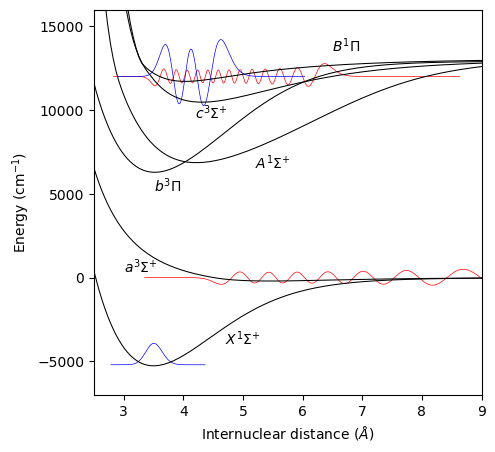

In [180]:
# PLOT RESULTS:

# initialize figures
fig, ax = plt.subplots(figsize=(5,5))

# plot wavefunctions:
scale_X1SP = max(Vr_X1SigmaPlus_array)/10
ax.plot(r[r_left_idx_X1SP:r_right_idx_X1SP:2],scale_X1SP*u_final_X1SP[::2]+E_final_X1SP, 'blue',linewidth=0.5)
scale_a3SP = max(Vr_a3SigmaPlus_array)/2
ax.plot(r[r_left_idx_a3SP:r_right_idx_a3SP:2],scale_a3SP*u_final_a3SP[::2]+E_final_a3SP, 'red',linewidth=0.5)
scale_c3SP = max(Vr_c3SigmaPlus_array)/400
ax.plot(r[r_left_idx_c3SP:r_right_idx_c3SP:2],scale_c3SP*u_final_c3SP[::2]+E_final_c3SP, 'red',linewidth=0.5)
scale_B1Pi = max(Vr_B1Pi_array)/200
ax.plot(r[r_left_idx_B1Pi:r_right_idx_B1Pi:2],scale_B1Pi*u_final_B1Pi[::2]+E_final_B1Pi, 'blue',linewidth=0.5)

# plot potentials
ax.plot(r[::100], Vr_X1SigmaPlus_array[::100],'k',linewidth=0.75)
ax.plot(r[::100], Vr_a3SigmaPlus_array[::100],'k',linewidth=0.75)
ax.plot(r[::100], Vr_B1Pi_array[::100],       'k',linewidth=0.75)
ax.plot(r[::100], Vr_c3SigmaPlus_array[::100],'k',linewidth=0.75)
ax.plot(r[::100], Vr_b3Pi_array[::100],       'k',linewidth=0.75)
ax.plot(r[::100], Vr_A1SigmaPlus_array[::100],'k',linewidth=0.75)

# label potentials
ax.annotate('$X^{1}\Sigma^{+}$', xy = (4.7,  -4000), xytext = (4.7,  -4000))
ax.annotate('$a^{3}\Sigma^{+}$', xy = (3  ,    300), xytext = (3  ,    300))
ax.annotate('$c^{3}\Sigma^{+}$', xy = (4.2,   9500), xytext = (4.2,   9500))
ax.annotate('$B^{1}\Pi$',        xy = (6.5,  13500), xytext = (6.5,  13500))
ax.annotate('$b^{3}\Pi$',        xy = (3.5,   5100), xytext = (3.5,   5100))
ax.annotate('$A^{1}\Sigma^{+}$', xy = (5.2,   6500), xytext = (5.2,   6500))

plt.xlim([2.5, 9])
plt.ylim([-7000, 16000])
plt.xlabel('Internuclear distance ($\AA$)')
plt.ylabel('Energy (cm$^{-1}$)')
plt.show()


# <font size=5, color='black'>NaK rotational and hyperfine structure calculator </font>

Some theory: The Hamiltonian which takes into account the rotational and hyperfine structure for a bi-alkali molecule (in our case NaK) is given by 
$$ H_\text{NaK} = H_\text{rot} + H_\text{hf} + H_\text{ext} $$
the basis that we will use for this Hamiltonian is the completely umcoupled basis $ \{ \ket{ (N, m_N), (i_Na, m_Na), (i_K, m_K)}    \}$ where $N$ is the ro


Here, the first term is just the Hamiltonian for the rigid rotor with an extra centrifugal distorsion term: 
$$ H_\text{rot} = B_\nu (\bf{N}\cdot \bf{N}) + \text{$D$}_\nu (\bf{N}\cdot \bf{N})^2 $$
where $B_\nu$ and $D_\nu$ are the rotational and distorsion constants associated with the vibrational level $\nu$, respectively.  

# <font size=5, color='black'> Zeeman Effect Calculator </font>

In [545]:
# helper functions
def A_hfs(J, I, mj, mi, mjj, mii):
    Ahfs = 0
    if (mj == mjj) and (mi == mii):
        Ahfs = mj*mi
    elif (mj == mjj + 1.0) and (mi == mii - 1.0):
        Ahfs = (1/2)*np.sqrt((J+mj)*(J-mj+1)*(I-mi)*(I+mi+1))
    elif (mj == mjj - 1.0) and (mi == mii + 1.0): 
        Ahfs = (1/2)*np.sqrt((J-mj)*(J+mj+1)*(I+mi)*(I-mi+1))
    else:
        Ahfs = 0
    return Ahfs

def B_hfs(J, I, mj, mi, mjj, mii):
    # reference: N. Ramsey's Molecular Beams... some Appendix, I believe
    Bhfs = 0
    if (mj == mjj) and (mi == mii):
        Bhfs = (1/2)*(3*mi**2-I*(I+1))*(3*mj**2-J*(J+1))
    elif (mj == mjj - 1) and (mi == mii + 1):   
        Bhfs = (3/4)*(2*mjj-1)*(2*mii+1)*np.sqrt((J+mjj)*(J-mjj+1)*(I-mii)*(I+mii+1))
    elif mj == mjj + 1 and mi == mii - 1:
        Bhfs = (3/4)*(2*mjj+1)*(2*mii-1)*np.sqrt((J-mjj)*(J+mjj+1)*(I+mii)*(I-mii+1))
    elif mj == mjj - 2 and mi == mii + 2 :  
        Bhfs = (3/4)*np.sqrt((J+mjj)*(J+mjj-1)*(J-mjj+1)*(J-mjj+2)*(I-mii)*(I-mii-1)*(I+mii+1)*(I+mii+2))
    elif mj == mjj + 2 and mi == mii - 2:
        Bhfs = (3/4)*np.sqrt((J-mjj)*(J-mjj-1)*(J+mjj+1)*(J+mjj+2)*(I+mii)*(I+mii-1)*(I-mii+1)*(I-mii+2))
    else:
        Bhfs = 0

    if (2*I*(2*I-1)*J*(2*J-1)) != 0:
        Bhfs = Bhfs/(2*I*(2*I-1)*J*(2*J-1))
    return Bhfs

def mag(B, J, L, S, mj, mi, mjj, mii, gI):
    gL = 1 - me/mn           # gyro magnetic factor of the orbital
    gS = 2.0023193043622     # electron spin g-factor
    gJ = gL*(J*(J+1)-S*(S+1)+L*(L+1))/(2*J*(J+1)) + gS*(J*(J+1)+S*(S+1)-L*(L+1))/(2*J*(J+1)) # verified, correct :)
    
    mag = 0
    if mj == mjj and mi == mii:
        mag = (muB/hbar)*(gJ*mj + gI*mi)*B*1e-4 # B is in Gauss, need to convert to Tesla
        # mag = (2*np.pi*1.4e6)*(gJ*mj + gI*mi)*B # from Alex's constants
    else:
        mag = 0

    return mag/(2*np.pi) # return answer in Hz

In [531]:
# zeeman splitting calculator
def zeeman_splitting_calculator(J, I, gI, L, S, B_main, B_start, B_end, num_B, Ahf, Bhf = 0, 
                                plotting = True, highlight_HF_states = [0,0], plot_range = None, 
                                single_B_field_calc_mode = False, print_field_sensitivity_between = None,
                                search_mode = False, splitting = 0, splitting_between_states = None):

    B_start = min(B_start, B_end)
    B_end = max(B_start, B_end)
    if num_B >= 20:
        B_fields = np.linspace(B_start, B_end, num_B)
        if B_main < max(B_fields) and B_main > min(B_fields):
            B_fields = np.append(B_fields, B_main)
            B_fields = np.sort(B_fields)
        else:
            print('The variable "B_main" is not in B fields!')
            return 0        
    else:
        print('Number of points must exceed 20!')
        return 0
    
    # possible Js
    possible_Js = np.arange(abs(L-S), abs(L+S)+1, 1)
    if J > max(possible_Js) or J < min(possible_Js):
        print('Invalid J!')
        return 0
    mJ = np.linspace(-J, J, int(2*J+1))
    mI = np.linspace(-I, I, int(2*I+1))

    # now make a basis:
    basis = [] # which is the set {[mj, mi]}
    for mj in mJ:
        for mi in mI:
            basis.append([mj, mi])
    size = len(basis)
    H = np.empty((size,size))
    list_of_freqs = [ ]

    # generate the zeeman Hamiltonian and diagonalize it 
    for b in B_fields:
        for r in range(size):
            mj = basis[r][0]
            mi = basis[r][1]
            for c in range(size):
                mjj = basis[c][0]
                mii = basis[c][1]
                H[r,c] = Ahf * A_hfs(J, I, mj, mi, mjj, mii) + Bhf * B_hfs(J, I, mj, mi, mjj, mii) + mag(b, J, L, S, mj, mi, mjj, mii, gI)
        freqs, eigenvectors = np.linalg.eigh(H) # calculate using the lower triangular part, can also do eig() -- same result
        freqs = freqs * 1e-6
        list_of_freqs.append(freqs)

    # Plotting and returning statistics:
    list_of_freqs = np.array(list_of_freqs)
    list_of_freqs = np.sort(list_of_freqs, axis=1)    
    highlight_HF_states = np.array(highlight_HF_states)
    if plotting:
        for s in range(size):
            plt.plot(B_fields, list_of_freqs[:,s], linewidth = 0.5, color='red')
        if highlight_HF_states.all() in np.arange(1, size+1,1):
            for state in highlight_HF_states:
                plt.plot(B_fields[np.where((B_fields == B_main))[0][0]:], 
                         list_of_freqs[np.where((B_fields == B_main))[0][0] : , state-1], linewidth = 1.5 , color = 'black')
        if plot_range is not None:
            plt.ylim(plot_range)
        plt.xlabel('Magnetic field (G)')
        plt.ylabel('Energy shift (MHz)')
        plt.grid()
        plt.show()   

    # Compute relevant statistics:
    if single_B_field_calc_mode:
        print('Frequency spacings (MHz), from low to high in state energy, at ' + str(B_main) +  ' G:')
        freqs = list_of_freqs[np.where(B_fields == B_main)[0][0]]
        for i in range(len(freqs)-1):
            print("{:.4f}".format(freqs[i+1] - freqs[i]))    
        print(' ')    
        # Field sensitivities:
        print('Field sensitivity of shift (MHz per G), from low to high in state energy, at ' + str(B_main) + ' G:')
        freqs_next = list_of_freqs[np.where(B_fields == B_main)[0][0] + 1]
        freqs_diff = freqs_next - freqs
        Bs_diff = B_fields[np.where(B_fields == B_main)[0][0] + 1] - B_fields[np.where(B_fields == B_main)[0][0]]
        for i in range(len(freqs)):
            print("{:.3f}".format(freqs_diff[i] / Bs_diff))  
        print(' ')

        # Next, calculate the difference between in energy between the two states:
        if print_field_sensitivity_between is not None:
            lower_state  = list_of_freqs[ : , print_field_sensitivity_between[0]-1]
            higher_state = list_of_freqs[ : , print_field_sensitivity_between[1]-1]
            differential_shift =  higher_state - lower_state
            # take derivative:
            dfdB = np.diff(differential_shift)/np.diff(B_fields)
            print( 'Field sensitivity of splitting, df'+str(print_field_sensitivity_between[1])+str(print_field_sensitivity_between[0])+' by dB:')   
            print("{:.4f}".format(dfdB[np.where((B_fields == B_main))[0][0]]) + ' MHz per G')

    # Search for B_field that matches splitting:
    if search_mode:
        if splitting_between_states is not None:
            state_A_freqs = list_of_freqs[ : , splitting_between_states[0]-1]
            state_B_freqs = list_of_freqs[ : , splitting_between_states[1]-1]
            AB_freq_differences = np.abs(state_B_freqs - state_A_freqs - splitting) # assuming no weird crossings...
            AB_freq_diff_min_index = np.argmin(AB_freq_differences)

            print(' ')
            print('Closest B field (G): ' + "{:.2f}".format(B_fields[AB_freq_diff_min_index]))
            splitting_error = state_B_freqs[AB_freq_diff_min_index] - state_A_freqs[AB_freq_diff_min_index] - splitting
            print('Splitting Error (MHz): ' + "{:.5f}".format(splitting_error ))
            if np.abs(splitting_error/splitting) >= 0.1: # if error is too big
                print('Note: large error might due to bad guesses!')

    return 

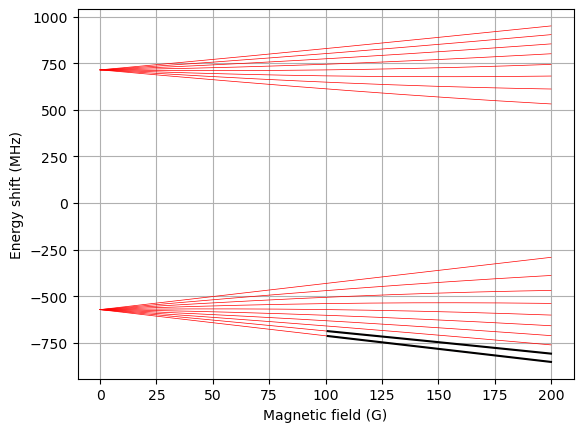

Frequency spacings (MHz), from low to high in state energy, at 101 G:
26.2370
27.1763
28.2244
29.4041
30.7456
32.2896
34.0927
36.2370
38.8456
1041.5567
36.1871
34.0428
32.2397
30.6957
29.3542
28.1745
27.1264
 
Field sensitivity of shift (MHz per G), from low to high in state energy, at 101 G:
-1.402
-1.186
-0.956
-0.710
-0.443
-0.153
0.167
0.525
0.931
1.402
-0.929
-0.524
-0.167
0.153
0.443
0.709
0.955
1.185
 
Field sensitivity of splitting, df21 by dB:
0.2158 MHz per G
 
Closest B field (G): 101.06
Splitting Error (MHz): 0.00102


In [558]:
# Zeeman calculator cell

B_start = 0
B_end = 200
B_main = 101 # G
num_B = 5000

# Careful what you type in here!
Ahf = K40Ahf_s12
Bhf = K40Bhf_s12
L = 0
S = 1/2
J = 1/2
I = K40I
gI = K40gI

zeeman_splitting_calculator(J, I, gI, L, S, B_main, B_start, B_end, num_B, Ahf, Bhf, 
                            plotting = True, highlight_HF_states = [1,2], plot_range = None, 
                            single_B_field_calc_mode = True, print_field_sensitivity_between = [1,2],
                            search_mode = True, splitting = 26.249, splitting_between_states = [1,2])

In [557]:
# on Jun 21, 2023, we found the resonance to be at 26.249 MHz
print('Detuning (kHz): ')
print((26.249 - 26.2370)*1e3)

# how much are we off by, field wise? 
print('Field error (mG):')
print((12 / 215.8)*1e3)

Detuning (kHz): 
12.000000000000455
Field error (mG):
55.60704355885078


# <font size=5, color='black'> Landau-Zener transition (linear sweep) </font>

In [449]:
# LZ solver
def LZ_solve(delta0, omegaR, ddelta_dt, psi0, tlist):

    # Hamiltonian
    sx = sigmax()
    sz = sigmaz()
    a = destroy(2)

    H0 = - (delta0/2.0) * sz - (omegaR/2.0) * sx
    H1 = - ddelta_dt/2.0 * sz        

    # collapse operators
    c_op_list = []

    # evolve and calculate expectation values. Method: Cython string-based
    # want to return expectation value of aTa = [[0,0],[0,1]] = P_excited
    H = [H0, [H1, 't']]
    output = mesolve(H, psi0, tlist, c_op_list, [a.dag() * a], {})  

    return output.expect[0]

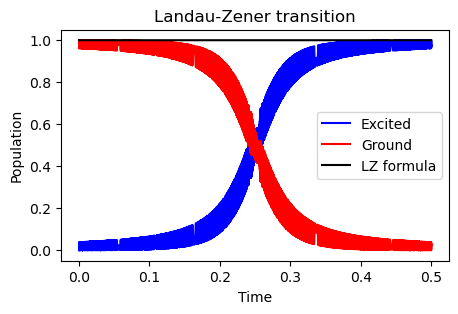

In [474]:
# calculate
sweep_time   = 100e-3              # sweep time in secs
sweep_span   = 100.0e3 * 2 * np.pi   # sweep span in Hz * 2pi, make sure this is >> omegaR for good LZ
sweep_center = 26.2370e6 * 2 * np.pi # sweep center in Hz * 2pi
ddelta_dt    = sweep_span/sweep_time   # sweep rate in Hz/s * 2pi
delta0       = -sweep_span/2   # initial detuning in Hz * 2pi
omegaR       = 10e3 * 2 * np.pi   # Rabi frequency in Hz * 2pi
psi0         = basis(2,0)      # initial state
tlist        = np.linspace(0, sweep_time, 10000)
p_ex         = LZ_solve(delta0, omegaR, ddelta_dt, psi0, tlist)

# display results
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(tlist, np.real(p_ex), 'b', tlist, np.real(1-p_ex), 'r')
ax.plot(tlist, 1 - np.exp(-np.pi * omegaR **2 / (2 * ddelta_dt)) * np.ones(shape(tlist)), 'k')
ax.set_xlabel('Time')
ax.set_ylabel('Population')
ax.set_title('Landau-Zener transition')
ax.legend(("Excited", "Ground", "LZ formula"), loc=0)
plt.show()

# <font size=5, color='black'> Rabi Solution for Two-Level System </font>

In [462]:
def _P2_Rabi(omega, tau, omegaR, omega0, offset):    
    OmegaR = np.sqrt( omegaR**2 + (omega - omega0)**2 )
    return ( omegaR**2 / OmegaR**2) * np.sin( 2*np.pi*OmegaR * tau / 2)**2 + offset

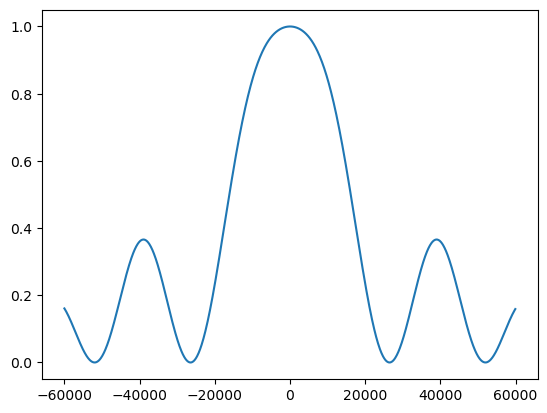

In [514]:
detunings = np.arange(-60e3,60e3,0.1e3)
omega0 = 26.2370e6
tau = 5e-5
omegaR = 30e3
offset = 0
P2 = _P2_Rabi(detunings+omega0, tau , omegaR, omega0, offset)
plt.plot(detunings, P2)
plt.show()

In [478]:
print(713.123623 - 686.881068)

26.242554999999925
